# Описание проекта.
Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Задача — обучить на этих данных модель для прогноза оттока клиентов. Найтие лучшую модель для прогноза оттока клиентов и оцените её качество метрикой ROC-AUC. Значение метрики ROC-AUC должно быть не менее 0.85

In [3]:
#! pip install phik

In [4]:
import pandas as pd
import numpy as np
import warnings
from datetime import datetime
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox, kruskal
import phik
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgbm
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, roc_curve
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, confusion_matrix
from tensorflow import keras

In [5]:
RANDOM_STATE = 15012024

# Подключение к БД

In [6]:
db_config = {
    'user':'praktikum_student',
    'pwd':'Sdf4$2;d-d30pp',
    'host':'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,
    'db': 'data-science-final'
}

In [7]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [8]:
engine = create_engine(connection_string)

# Загрзка данных

## Contract

In [9]:
query = '''
    SELECT * FROM telecom.contract
'''

contract = pd.DataFrame(engine.connect().execute(text(query)))

In [10]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,None
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,None
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,None
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.7,151.65


In [11]:
contract.columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paper_less_billing', 'payment_method', 'montly_charges', 'total_charges']

In [12]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         7043 non-null   object
 1   begin_date          7043 non-null   object
 2   end_date            1869 non-null   object
 3   type                7043 non-null   object
 4   paper_less_billing  7043 non-null   object
 5   payment_method      7043 non-null   object
 6   montly_charges      7043 non-null   object
 7   total_charges       7032 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB


имеются пропущенные значения в total_charges и в end_date

## Personal

In [13]:
query = '''
    SELECT * FROM telecom.personal
'''

personal = pd.DataFrame(engine.connect().execute(text(query)))

In [14]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [15]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [16]:
personal.columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']

In [17]:
personal.loc[personal['senior_citizen'] == 1, 'senior_citizen'] = 'yes'
personal.loc[personal['senior_citizen'] == 0, 'senior_citizen'] = 'no'

## Internet

In [18]:
query = '''
    SELECT * FROM telecom.internet
'''

internet = pd.DataFrame(engine.connect().execute(text(query)))

In [19]:
internet.head()

,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No


In [20]:
internet.columns = ['customer_id', 'internet_service', 'online_security',
                    'online_backup', 'device_protection', 'tech_support',
                    'streamong_tv', 'streaming_movies']

In [21]:
internet = internet.drop(index=0)

In [22]:
internet.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streamong_tv,streaming_movies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
5,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [23]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 1 to 5517
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streamong_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


## Phone

In [24]:
query = '''
    SELECT * FROM telecom.phone
'''

phone = pd.DataFrame(engine.connect().execute(text(query)))

In [25]:
phone.head()

,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes


In [26]:
phone.columns = ['customer_id', 'multiple_lines']

In [27]:
phone = phone.drop(index=0)

In [28]:
phone.head()

,customer_id,multiple_lines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
5,1452-KIOVK,Yes


In [29]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 1 to 6361
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


# 1.Предобработка данных

Уберу заглавные буквы, пробелы и инные знаки припенания в категориальных столбцах

In [30]:
def data_preprocessing(data, columns):
    for col in columns:
        data[col] = data[col].str.lower()
        data[col] = data[col].str.replace(r'[\s-]', '_')
    return data

In [31]:
def show_all_values(data, columns):
    for col in columns:
        print('=========', col, '==============')
        print(data[col].value_counts())
        print('============================')

In [32]:
contract = data_preprocessing(contract, ['type', 'paper_less_billing', 'payment_method'])
personal = data_preprocessing(personal, ['gender','partner', 'dependents'])
internet = data_preprocessing(internet, internet.columns[1:])
phone = data_preprocessing(phone, ['multiple_lines'])

<ipython-input-30-cc74fef055c6>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  data[col] = data[col].str.replace(r'[\s-]', '_')


### Поиск неявных дубликатов

Contract

In [33]:
show_all_values(contract, ['type', 'paper_less_billing', 'payment_method'])

========= type ==============
month_to_month    3875
two_year          1695
one_year          1473
Name: type, dtype: int64
========= paper_less_billing ==============
yes    4171
no     2872
Name: paper_less_billing, dtype: int64
========= payment_method ==============
electronic_check             2365
mailed_check                 1612
bank_transfer_(automatic)    1544
credit_card_(automatic)      1522
Name: payment_method, dtype: int64


Personal

In [34]:
show_all_values(personal, ['gender','partner', 'dependents'])

========= gender ==============
male      3555
female    3488
Name: gender, dtype: int64
========= partner ==============
no     3641
yes    3402
Name: partner, dtype: int64
========= dependents ==============
no     4933
yes    2110
Name: dependents, dtype: int64


Internet

In [35]:
show_all_values(internet, internet.columns[1:])

========= internet_service ==============
fiber_optic    3096
dsl            2421
Name: internet_service, dtype: int64
========= online_security ==============
no     3498
yes    2019
Name: online_security, dtype: int64
========= online_backup ==============
no     3088
yes    2429
Name: online_backup, dtype: int64
========= device_protection ==============
no     3095
yes    2422
Name: device_protection, dtype: int64
========= tech_support ==============
no     3473
yes    2044
Name: tech_support, dtype: int64
========= streamong_tv ==============
no     2810
yes    2707
Name: streamong_tv, dtype: int64
========= streaming_movies ==============
no     2785
yes    2732
Name: streaming_movies, dtype: int64


Phone

In [36]:
show_all_values(phone, ['multiple_lines'])

========= multiple_lines ==============
no     3390
yes    2971
Name: multiple_lines, dtype: int64


Неявных дубликатов нету

## Поиск явных дубликатов

Contract

In [37]:
contract[contract.duplicated()].count()

customer_id           0
begin_date            0
end_date              0
type                  0
paper_less_billing    0
payment_method        0
montly_charges        0
total_charges         0
dtype: int64

personal

In [38]:
personal[personal.duplicated()].count()

customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

internet

In [39]:
internet[internet.duplicated()].count()

customer_id          0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streamong_tv         0
streaming_movies     0
dtype: int64

In [40]:
phone[phone.duplicated()].count()

customer_id       0
multiple_lines    0
dtype: int64

Явных дубликатов нету

# 2.Исследовательский анализ
Проверить наличие пропусков и аномалий, изучить распределение признаков для каждой таблицы.

In [61]:
def plot_data_dist(data,columns, row, col, hist, figsize, fontsize, is_cat):
    num_col = 0
    hist_columns = [sns.histplot, sns.countplot];
    for row in range(row):
        for h in range(hist):
            if num_col <= len(columns) - 1:
                ax = plt.subplot(1, col, h + 1)
                sns.set(rc={'figure.figsize':figsize})
                hist_columns[is_cat](data = data, x=columns[num_col])
                ax.set_xlabel(columns[num_col], fontsize=fontsize)
                ax.set_ylabel(columns[num_col], fontsize=fontsize)
                ax.set_title(columns[num_col] + '_' + 'distribution')
                num_col += 1
            else:
                return
        plt.show()

## Contract

In [62]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         7043 non-null   object 
 1   begin_date          7043 non-null   object 
 2   end_date            1869 non-null   object 
 3   type                7043 non-null   object 
 4   paper_less_billing  7043 non-null   object 
 5   payment_method      7043 non-null   object 
 6   montly_charges      7043 non-null   float64
 7   total_charges       7043 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


Есть пропущенные значения в total_charges. Посмотрю подробно пропущенные значения

In [63]:
pass_total_chrages = contract[contract['total_charges'].isnull()]

In [64]:
for col in pass_total_chrages.columns:
    if len(pass_total_chrages[col].value_counts()) != 0:
        print(pass_total_chrages[col].value_counts())
        print('==============================')

In [65]:
contract[contract['begin_date'] == pd.to_datetime('2020-02-01')]

,customer_id,begin_date,end_date,type,paper_less_billing,payment_method,montly_charges,total_charges
0,4472-LVYGI,2020-02-01,None,two_year,yes,bank_transfer_(automatic),52.55,52.55
1,3115-CZMZD,2020-02-01,None,two_year,no,mailed_check,20.25,20.25
3,5709-LVOEQ,2020-02-01,None,two_year,no,mailed_check,80.85,80.85
6,4367-NUYAO,2020-02-01,None,two_year,no,mailed_check,25.75,25.75
7,1371-DWPAZ,2020-02-01,None,two_year,no,credit_card_(automatic),56.05,56.05
9,3213-VVOLG,2020-02-01,None,two_year,no,mailed_check,25.35,25.35
10,2923-ARZLG,2020-02-01,None,one_year,yes,mailed_check,19.70,19.70
11,2775-SEFEE,2020-02-01,None,two_year,yes,bank_transfer_(automatic),61.90,61.90
4408,7644-OMVMY,2020-02-01,None,two_year,no,mailed_check,19.85,19.85
5160,2520-SGTTA,2020-02-01,None,two_year,no,mailed_check,20.00,20.00


все пропущенные значения в total_charges имеют begin_date '2020-02-01', что является датой выгрузки, то есть это новые клиенты у которых еще не подситано total_cahrges, а только montly_charges. Заполню пропуски в total_charges

In [66]:
contract.loc[contract['total_charges'].isnull(), 'total_charges'] = contract['montly_charges']

In [67]:
contract['montly_charges'] = contract['montly_charges'].astype(float)
contract['total_charges'] = contract['total_charges'].astype(float)

посмотрю подробно на значения в колонке type

In [68]:
contract['type'].value_counts()

month_to_month    3875
two_year          1695
one_year          1473
Name: type, dtype: int64

### Поиск аномальных значений

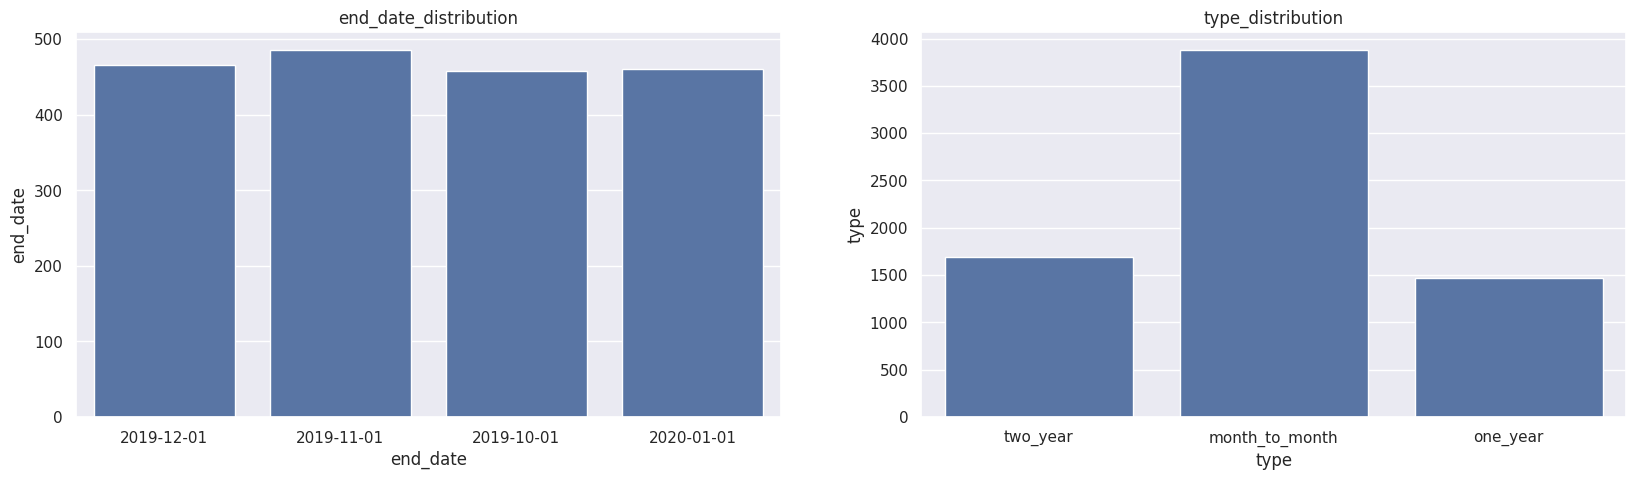

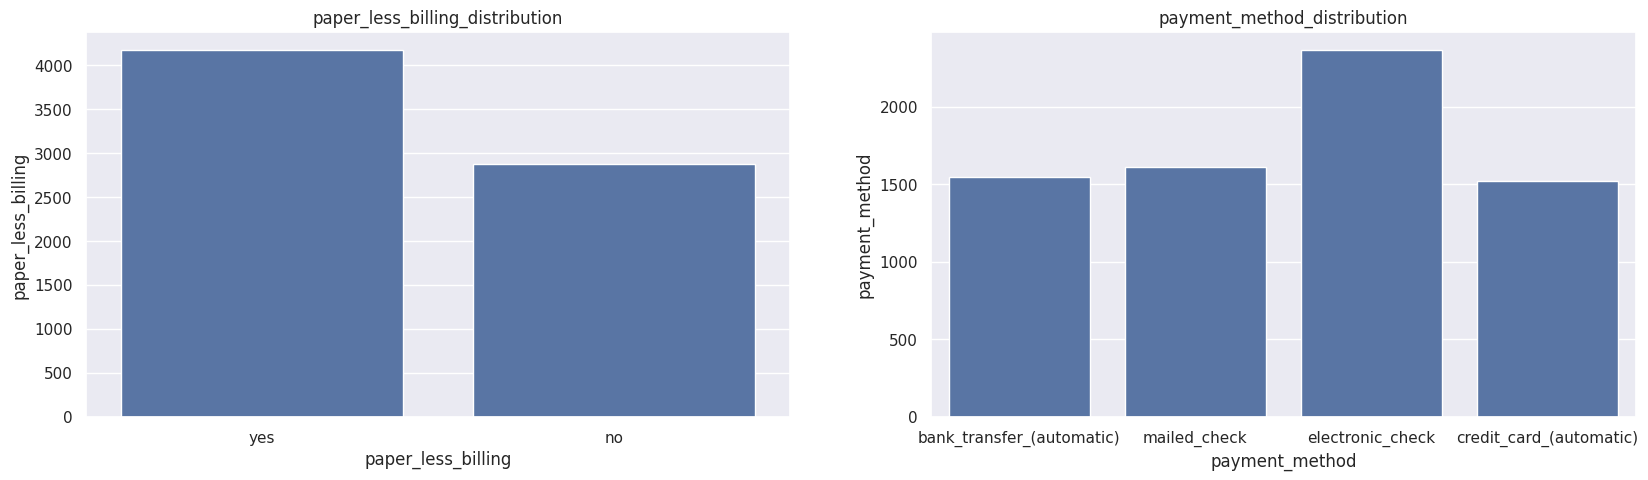

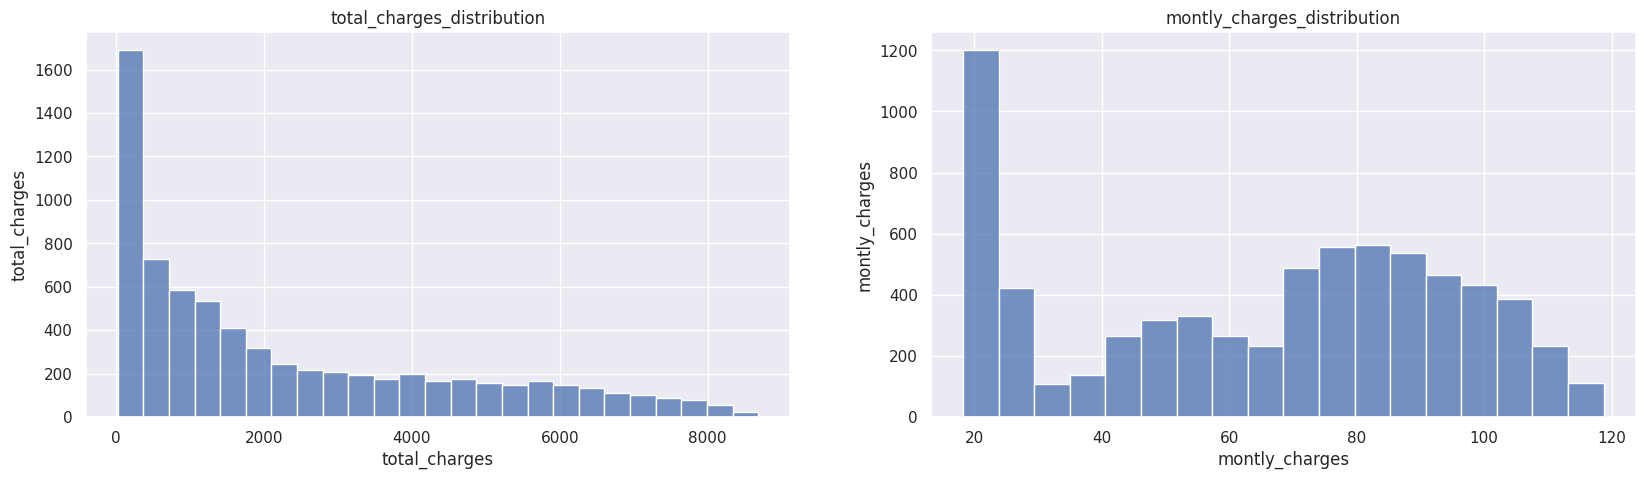

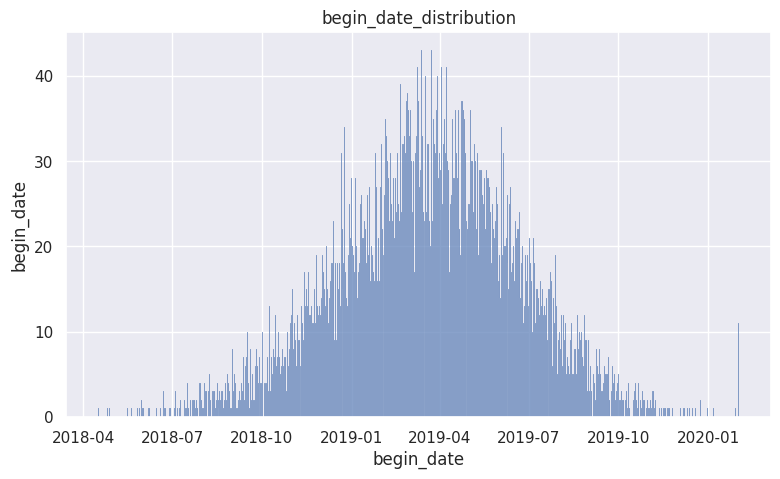

In [70]:
warnings.filterwarnings('ignore')
type_cols = {'cat_cols': ['end_date', 'type', 'paper_less_billing', 'payment_method'],
            'num_cols': ['total_charges', 'montly_charges', 'begin_date']}


plot_data_dist(contract, type_cols['cat_cols'], 4, 2, 2, figsize=(20, 5), fontsize=12, is_cat=True)
plot_data_dist(contract, type_cols['num_cols'], 2, 2, 2, figsize=(20, 5), fontsize=12, is_cat=False)

Имеется выброс в признаке montly_charges и в total_charges дисбаланс в type. Остальные признаки распределены более менее равномерно. В begin_data данные имеют гаусовское распределение, что выглядит странным, так как получается, что был пик, причем, давольно резкий,  когда пришло много клиентов, а потом резкий спад. Куда более логичное распределение близкое к равномерному. Возможно это связано с тем, что компания проводила активную рекламу своих услуг из-за чего пришло много клиентов, но их неудалось удержать и все те, кто быстро пришли, также быстро ушли.

### Обработка выбрсов

#### total_charges

count    7043.000000
mean     2279.798992
std      2266.730170
min        18.800000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: total_charges, dtype: float64

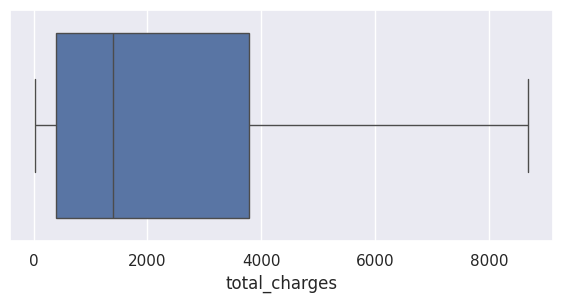

In [71]:
sns.set(rc={'figure.figsize':(7,3)})
sns.boxplot(contract['total_charges'], orient='h')
contract['total_charges'].describe()

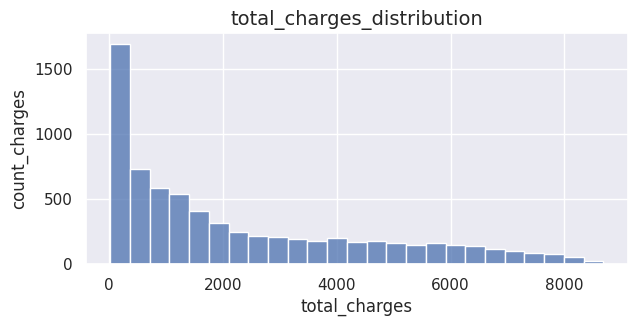

In [72]:
sns.histplot(contract['total_charges'])
sns.set(rc={'figure.figsize':(15,6)})
plt.xlabel('total_charges', fontsize=12)
plt.ylabel('count_charges', fontsize=12)
plt.title('total_charges_distribution', fontsize=14)
plt.grid(True)
plt.show();

25 % данных лежит до отметки 400, а мнимальное значение равно 18.8, что с технической точки зрения является аномальностью. Однако объяснить это можно тем, что клиенты возможно не заинтересованы в услугах и не пользуются ими, поэтому и такие низкие траты или это клиенты, которые только недавно оформили услуги или Если вспоинить, что в один момент был пик притока новых клиентов, а позже резкий отток, то такая теория выглядт логичной. Также распределение имеет вид экспаненциального, поэтому в низкие тарты имееют информацию

#### montly_charges

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: montly_charges, dtype: float64

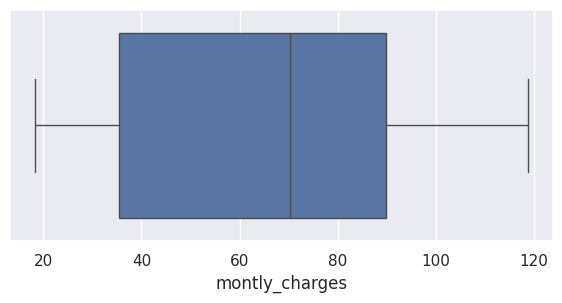

In [73]:
sns.set(rc={'figure.figsize':(7,3)})
sns.boxplot(contract['montly_charges'], orient='h')
contract['montly_charges'].describe()

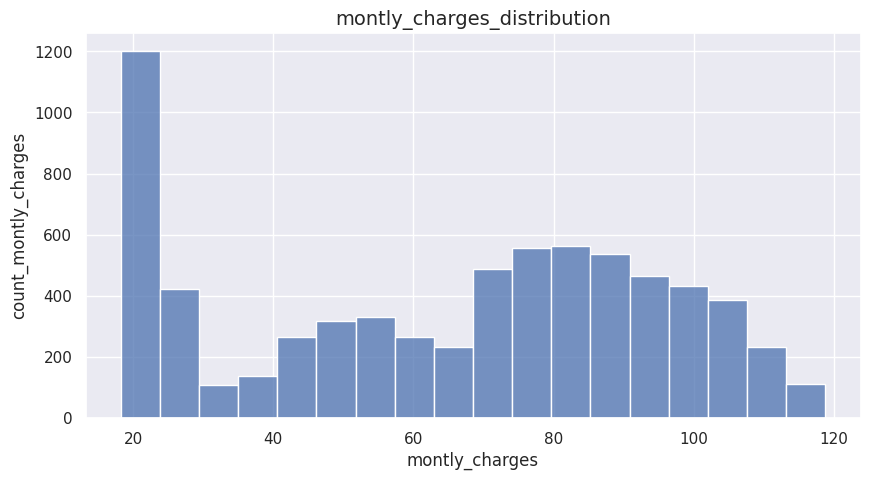

In [74]:
sns.set(rc={'figure.figsize':(10,5)})
sns.histplot(contract['montly_charges']);
plt.xlabel('montly_charges', fontsize=12)
plt.ylabel('count_montly_charges', fontsize=12)
plt.title('montly_charges_distribution', fontsize=14)
plt.grid(True)
plt.show();

Данные имеют нормально распределение, однако также имеется выброс. Очень много малых трат за месяц. Вожмножно, это также связано с тем, что клиенты не заинтересованные в использовании услуг и пришли в периуд активной рекламы, а потом также ушли. Возможно клиенты, которые мало тратили за месяц, также мало тратили и за все время и это новые клиенты.

In [75]:
anomal_charges = contract[(contract['montly_charges'] < 35)&(contract['total_charges'] < 400)][['type', 'montly_charges', 'total_charges']]
anomal_charges_per = anomal_charges.shape[0] / contract[contract['montly_charges'] < 35]['montly_charges'].shape[0]

In [76]:
print('Процент клиентов, которые трпатили мало за месяц и за все время: ', anomal_charges_per)

Процент клиентов, которые трпатили мало за месяц и за все время:  0.4506065857885615


45 % клиентов, если тратили мало за месяц, то также мало тратили за все время. Возможно клиенты, которые тратили мало за месяц и за все время, выбирали тип оплаты раз в месяц, так как были не заинтересованы в сервисе и не готовы били покупать услуги на год или два или это новые клиенты

month_to_month    566
one_year          130
two_year           84
Name: type, dtype: int64

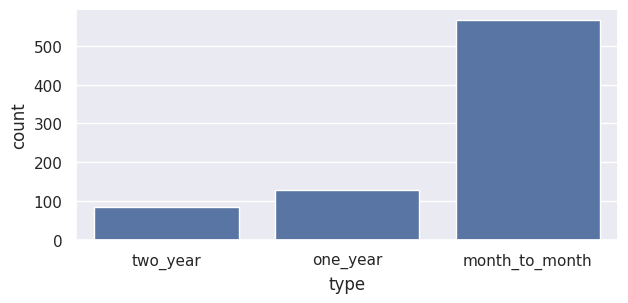

In [77]:
sns.set(rc={'figure.figsize':(7,3)})
sns.countplot(anomal_charges, x='type');
anomal_charges['type'].value_counts()

в большинтсве случаев если человек тратил за месяц мало и мало тратил за все вреемя, то он платил только ежемесяцно, так как скорее всего был не заинтересован в услугах. Таким образом, малдые траты за месяц имеют небольшую взаимосвязь с тпом оплаты и количестовм трат за все время, что говорит о том, что клиенты малые траты - это траты клиентов, которые недавно формили услуги.

## Personal

In [78]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   object
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


Пропущенных значений нет

### Поиск аномальных значений и выбросов

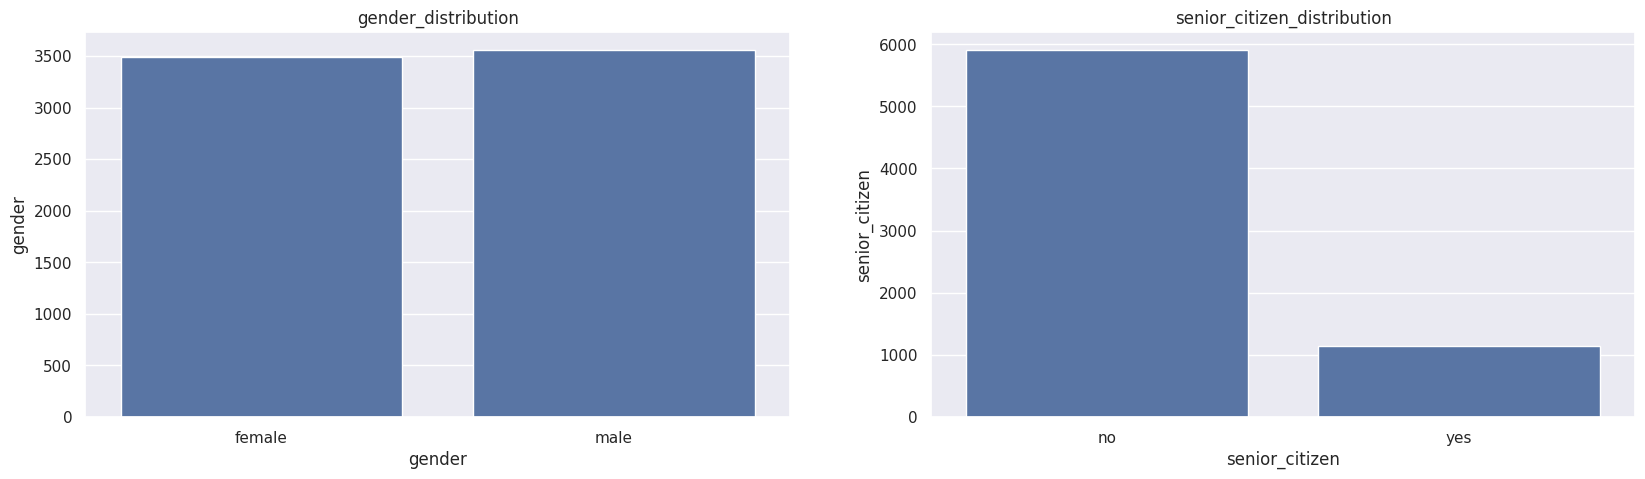

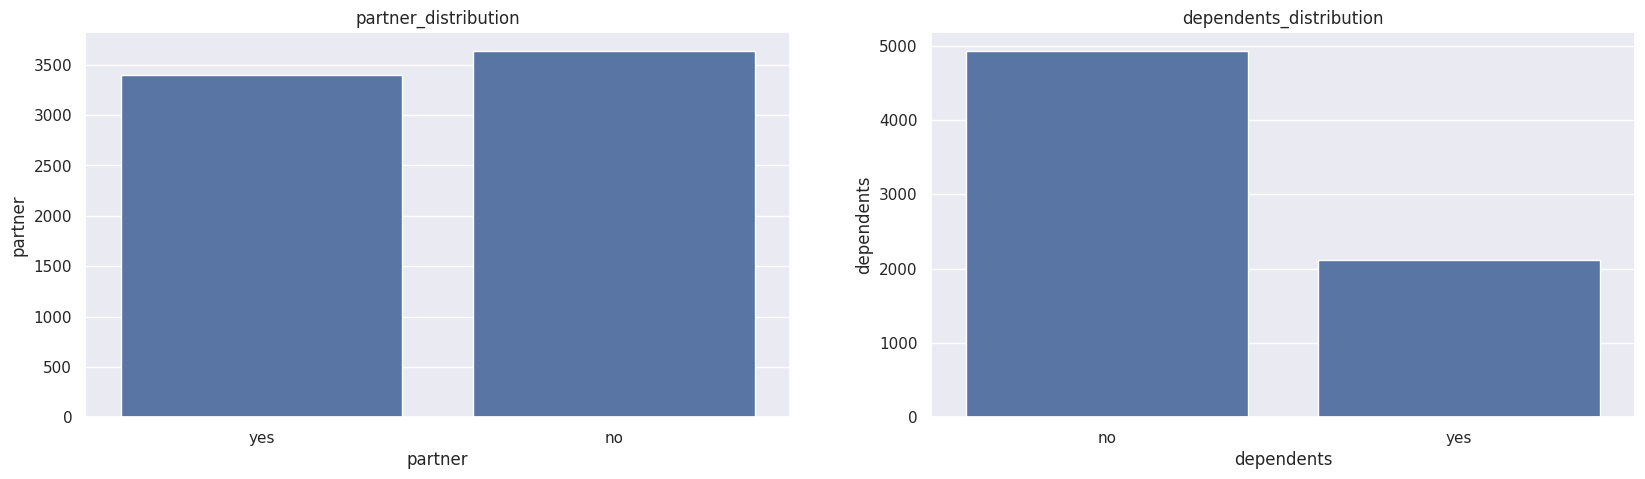

In [80]:
plot_data_dist(personal, personal.columns[1:], 2, 2, 2, figsize=(20, 5), fontsize=12, is_cat=True)

Аномальных значений не наблюдается, выбросов нету. Имеется дисбаланс в dependents и senior, во все осталььные признаки распределены более менее равномерно

## Internet

In [81]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 1 to 5517
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streamong_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Пропусков нету

### Поиск аномальных значений

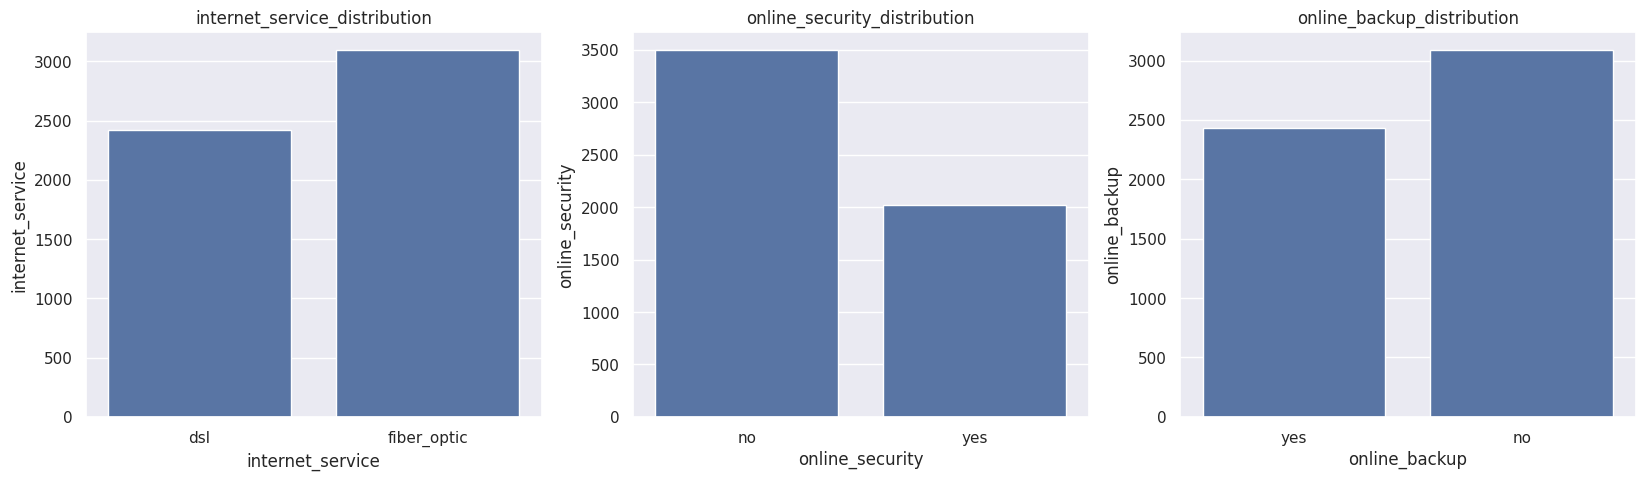

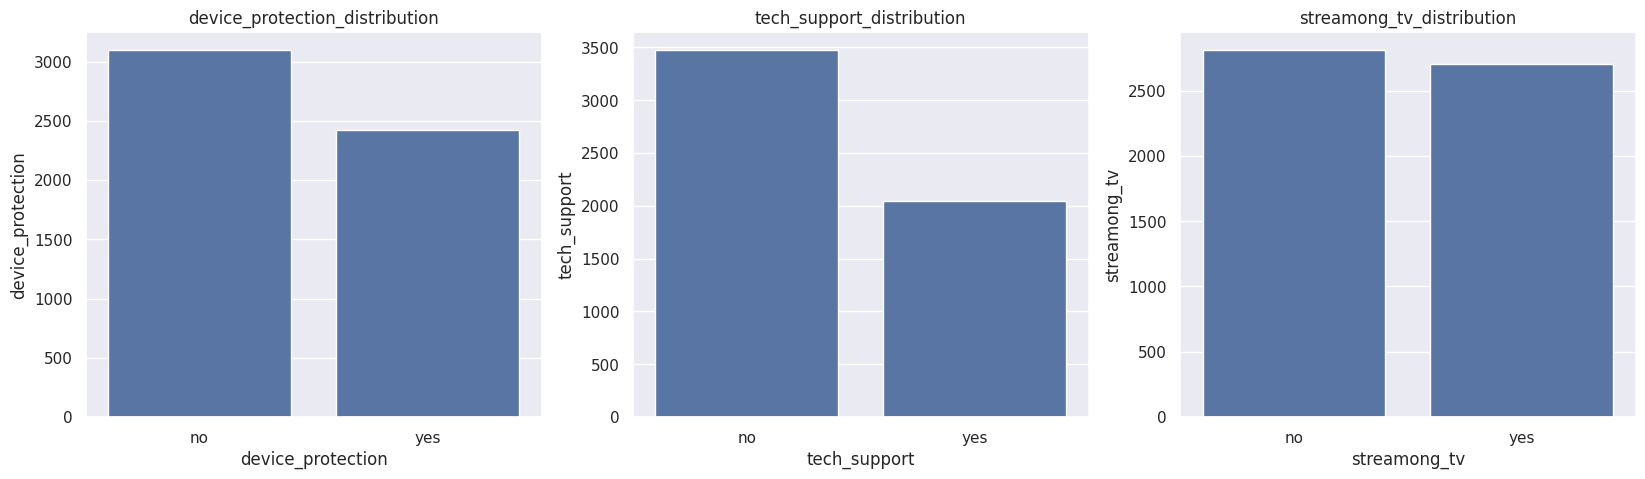

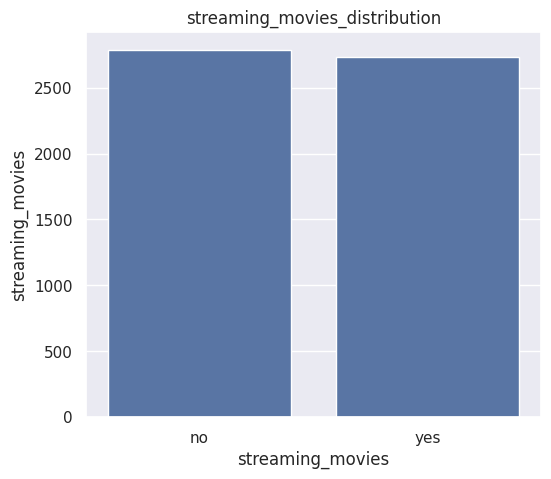

In [82]:
plot_data_dist(internet, internet.columns[1:], 3, 3, 3, figsize=(20, 5), fontsize=12, is_cat=True)

Аномальных значений и выбросов нету. Имеется небольшой дисбаланс в tech_support и online_security

# Phone

In [83]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 1 to 6361
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Пропусков нету

### Поиск аномальных значений

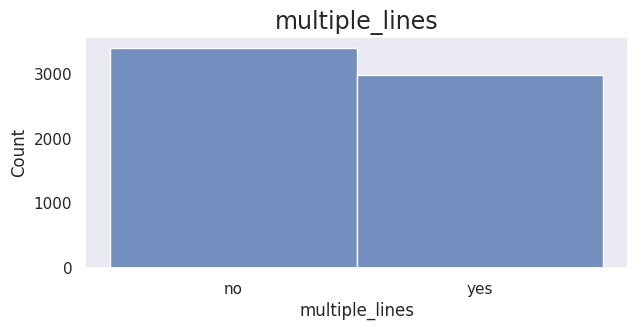

In [84]:
sns.set(rc={'figure.figsize':(7,3)})
sns.histplot(phone['multiple_lines']);
plt.title('multiple_lines', fontsize=17)
plt.grid()
plt.show()

Данные распределены равномерно. Аномальных значений и выбросов нету

# Соединение таблиц

In [85]:
main_df = contract.merge(personal, how='outer', on='customer_id')
main_df = main_df.merge(internet, how='outer', on='customer_id')
main_df = main_df.merge(phone, how='outer', on = 'customer_id')

In [86]:
main_df

,customer_id,begin_date,end_date,type,paper_less_billing,payment_method,montly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streamong_tv,streaming_movies,multiple_lines
0,4472-LVYGI,2020-02-01,None,two_year,yes,bank_transfer_(automatic),52.55,52.55,female,no,yes,yes,dsl,yes,no,yes,yes,yes,no,NaN
1,3115-CZMZD,2020-02-01,None,two_year,no,mailed_check,20.25,20.25,male,no,no,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no
2,3668-QPYBK,2018-08-09,2019-12-01,month_to_month,yes,mailed_check,53.85,108.15,male,no,no,no,dsl,yes,yes,no,no,no,no,no
3,5709-LVOEQ,2020-02-01,None,two_year,no,mailed_check,80.85,80.85,female,no,yes,yes,dsl,yes,yes,yes,no,yes,yes,no
4,9237-HQITU,2019-01-26,2019-11-01,month_to_month,yes,electronic_check,70.70,151.65,female,no,no,no,fiber_optic,no,no,no,no,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,None,two_year,yes,bank_transfer_(automatic),21.15,1419.40,female,no,no,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no
7039,6840-RESVB,2019-02-26,None,one_year,yes,mailed_check,84.80,1990.50,male,no,yes,yes,dsl,yes,no,yes,yes,yes,yes,yes
7040,2234-XADUH,2019-09-02,None,one_year,yes,credit_card_(automatic),103.20,7362.90,female,no,yes,yes,fiber_optic,no,yes,yes,no,yes,yes,yes
7041,4801-JZAZL,2019-06-26,None,month_to_month,yes,electronic_check,29.60,346.45,female,no,yes,yes,dsl,yes,no,no,no,no,no,NaN


In [87]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         7043 non-null   object 
 1   begin_date          7043 non-null   object 
 2   end_date            1869 non-null   object 
 3   type                7043 non-null   object 
 4   paper_less_billing  7043 non-null   object 
 5   payment_method      7043 non-null   object 
 6   montly_charges      7043 non-null   float64
 7   total_charges       7043 non-null   float64
 8   gender              7043 non-null   object 
 9   senior_citizen      7043 non-null   object 
 10  partner             7043 non-null   object 
 11  dependents          7043 non-null   object 
 12  internet_service    5517 non-null   object 
 13  online_security     5517 non-null   object 
 14  online_backup       5517 non-null   object 
 15  device_protection   5517 non-null   object 
 16  tech_s

In [88]:
main_df[main_df.duplicated(['customer_id'])].count()

customer_id           0
begin_date            0
end_date              0
type                  0
paper_less_billing    0
payment_method        0
montly_charges        0
total_charges         0
gender                0
senior_citizen        0
partner               0
dependents            0
internet_service      0
online_security       0
online_backup         0
device_protection     0
tech_support          0
streamong_tv          0
streaming_movies      0
multiple_lines        0
dtype: int64

In [89]:
main_df.duplicated().sum()

0

Добавлю новый признак leave, который будет целевой переменной и признак duration, который будет показывать длительность контракта. Если дата оконсания контракта указана, то клиент ушел и leave будет равен 1, иначе 0. Признак end_date удалю. Но для начала заполню пропущенные значения в end_date датой выгрузки - 01.02.2020

In [90]:
def is_leave(col):
    if pd.isna(col):
        return 0
    else:
        return 1

In [91]:
main_df['leave'] = main_df['end_date'].apply(is_leave)

In [92]:
main_df['end_date'] = main_df['end_date'].fillna(pd.to_datetime('2020-02-01', format='%Y-%m-%d'))
main_df['end_date'] = pd.to_datetime(main_df['end_date']).dt.date

Duration

In [93]:
main_df['duration'] = (main_df['end_date'] - main_df['begin_date']).dt.days

In [94]:
main_df = main_df.drop('end_date', axis=1)

In [95]:
main_df

,customer_id,begin_date,type,paper_less_billing,payment_method,montly_charges,total_charges,gender,senior_citizen,partner,...,internet_service,online_security,online_backup,device_protection,tech_support,streamong_tv,streaming_movies,multiple_lines,leave,duration
0,4472-LVYGI,2020-02-01,two_year,yes,bank_transfer_(automatic),52.55,52.55,female,no,yes,...,dsl,yes,no,yes,yes,yes,no,NaN,0,0
1,3115-CZMZD,2020-02-01,two_year,no,mailed_check,20.25,20.25,male,no,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,0,0
2,3668-QPYBK,2018-08-09,month_to_month,yes,mailed_check,53.85,108.15,male,no,no,...,dsl,yes,yes,no,no,no,no,no,1,479
3,5709-LVOEQ,2020-02-01,two_year,no,mailed_check,80.85,80.85,female,no,yes,...,dsl,yes,yes,yes,no,yes,yes,no,0,0
4,9237-HQITU,2019-01-26,month_to_month,yes,electronic_check,70.70,151.65,female,no,no,...,fiber_optic,no,no,no,no,no,no,no,1,279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,two_year,yes,bank_transfer_(automatic),21.15,1419.40,female,no,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,0,376
7039,6840-RESVB,2019-02-26,one_year,yes,mailed_check,84.80,1990.50,male,no,yes,...,dsl,yes,no,yes,yes,yes,yes,yes,0,340
7040,2234-XADUH,2019-09-02,one_year,yes,credit_card_(automatic),103.20,7362.90,female,no,yes,...,fiber_optic,no,yes,yes,no,yes,yes,yes,0,152
7041,4801-JZAZL,2019-06-26,month_to_month,yes,electronic_check,29.60,346.45,female,no,yes,...,dsl,yes,no,no,no,no,no,NaN,0,220


# Обработка пропусков

In [96]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         7043 non-null   object 
 1   begin_date          7043 non-null   object 
 2   type                7043 non-null   object 
 3   paper_less_billing  7043 non-null   object 
 4   payment_method      7043 non-null   object 
 5   montly_charges      7043 non-null   float64
 6   total_charges       7043 non-null   float64
 7   gender              7043 non-null   object 
 8   senior_citizen      7043 non-null   object 
 9   partner             7043 non-null   object 
 10  dependents          7043 non-null   object 
 11  internet_service    5517 non-null   object 
 12  online_security     5517 non-null   object 
 13  online_backup       5517 non-null   object 
 14  device_protection   5517 non-null   object 
 15  tech_support        5517 non-null   object 
 16  stream

Пропуски в данных имеются в столбцах с информацией о телефонных и интернет услугаз. Это вызваны тем, что размеры таблицы с телефоннами услугами и интернет услугами не совпадают, так как есть клиенты, которые имеют только телефонные услуги или только интернет услуги. Клиенты, которые имеют только телефонные услуги во всех интернет услугах имеют пропуски, и наоборот, клиенты которые имеют только интернет услуги имеют пропуски в таблице с телефоннами услугами. В таком случае, если значение пропущено, то это значит, что клиент не имеет данную услугу. Заполню все пропуски значением "absent"

In [97]:
for col in main_df.columns[11:19]:
    main_df[col] = main_df[col].fillna('absent')

In [98]:
main_df

,customer_id,begin_date,type,paper_less_billing,payment_method,montly_charges,total_charges,gender,senior_citizen,partner,...,internet_service,online_security,online_backup,device_protection,tech_support,streamong_tv,streaming_movies,multiple_lines,leave,duration
0,4472-LVYGI,2020-02-01,two_year,yes,bank_transfer_(automatic),52.55,52.55,female,no,yes,...,dsl,yes,no,yes,yes,yes,no,absent,0,0
1,3115-CZMZD,2020-02-01,two_year,no,mailed_check,20.25,20.25,male,no,no,...,absent,absent,absent,absent,absent,absent,absent,no,0,0
2,3668-QPYBK,2018-08-09,month_to_month,yes,mailed_check,53.85,108.15,male,no,no,...,dsl,yes,yes,no,no,no,no,no,1,479
3,5709-LVOEQ,2020-02-01,two_year,no,mailed_check,80.85,80.85,female,no,yes,...,dsl,yes,yes,yes,no,yes,yes,no,0,0
4,9237-HQITU,2019-01-26,month_to_month,yes,electronic_check,70.70,151.65,female,no,no,...,fiber_optic,no,no,no,no,no,no,no,1,279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,two_year,yes,bank_transfer_(automatic),21.15,1419.40,female,no,no,...,absent,absent,absent,absent,absent,absent,absent,no,0,376
7039,6840-RESVB,2019-02-26,one_year,yes,mailed_check,84.80,1990.50,male,no,yes,...,dsl,yes,no,yes,yes,yes,yes,yes,0,340
7040,2234-XADUH,2019-09-02,one_year,yes,credit_card_(automatic),103.20,7362.90,female,no,yes,...,fiber_optic,no,yes,yes,no,yes,yes,yes,0,152
7041,4801-JZAZL,2019-06-26,month_to_month,yes,electronic_check,29.60,346.45,female,no,yes,...,dsl,yes,no,no,no,no,no,absent,0,220


In [99]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         7043 non-null   object 
 1   begin_date          7043 non-null   object 
 2   type                7043 non-null   object 
 3   paper_less_billing  7043 non-null   object 
 4   payment_method      7043 non-null   object 
 5   montly_charges      7043 non-null   float64
 6   total_charges       7043 non-null   float64
 7   gender              7043 non-null   object 
 8   senior_citizen      7043 non-null   object 
 9   partner             7043 non-null   object 
 10  dependents          7043 non-null   object 
 11  internet_service    7043 non-null   object 
 12  online_security     7043 non-null   object 
 13  online_backup       7043 non-null   object 
 14  device_protection   7043 non-null   object 
 15  tech_support        7043 non-null   object 
 16  stream

# Визуальный анализ данных
Визуализирую распределение признаков для и оставшихся и не оставшихся клиентов

In [100]:
is_leave = main_df[main_df['leave'] == 1]
not_leave = main_df[main_df['leave'] == 0]
columns = np.array(main_df.columns[1:])
num_columns = ['total_charges', 'montly_charges', 'duration', 'begin_date']


cat_columns = np.delete(columns, np.where(columns == 'leave')[0][0])
cat_cols = np.delete(cat_columns, np.where(np.isin(cat_columns, num_columns)))

In [101]:
def visual_analysis(is_leave, not_leave, cols, figsize, is_cat):
    hist_func = [sns.histplot, sns.countplot]
    for i in range(len(cols)):
        ax1 = plt.subplot(1, 2, 1, label=cols[i])
        sns.set(rc={'figure.figsize':figsize})
        hist_func[is_cat](data=is_leave, x=cols[i])
        plt.title('is_leave', fontsize=20)

        ax2 = plt.subplot(1, 2, 2, label=cols[i])
        sns.set(rc={'figure.figsize':figsize})
        hist_func[is_cat](data=not_leave, x=cols[i])
        plt.title('not_leave', fontsize=20);
        plt.show()

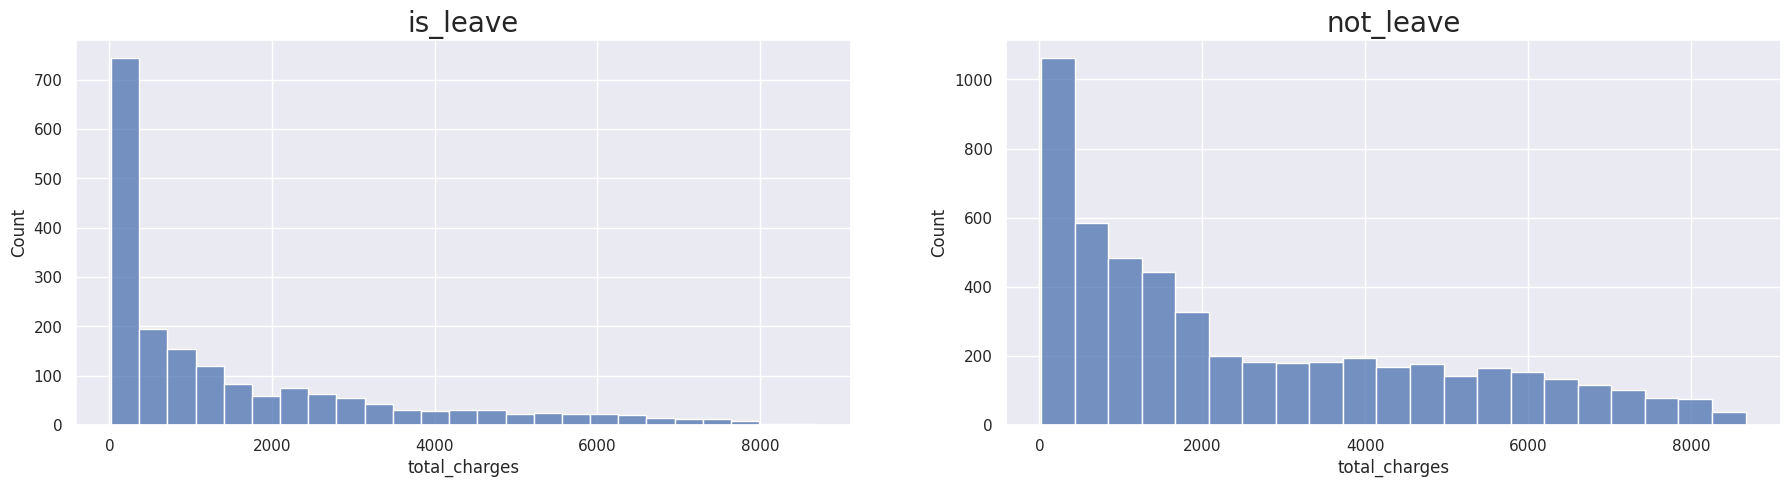

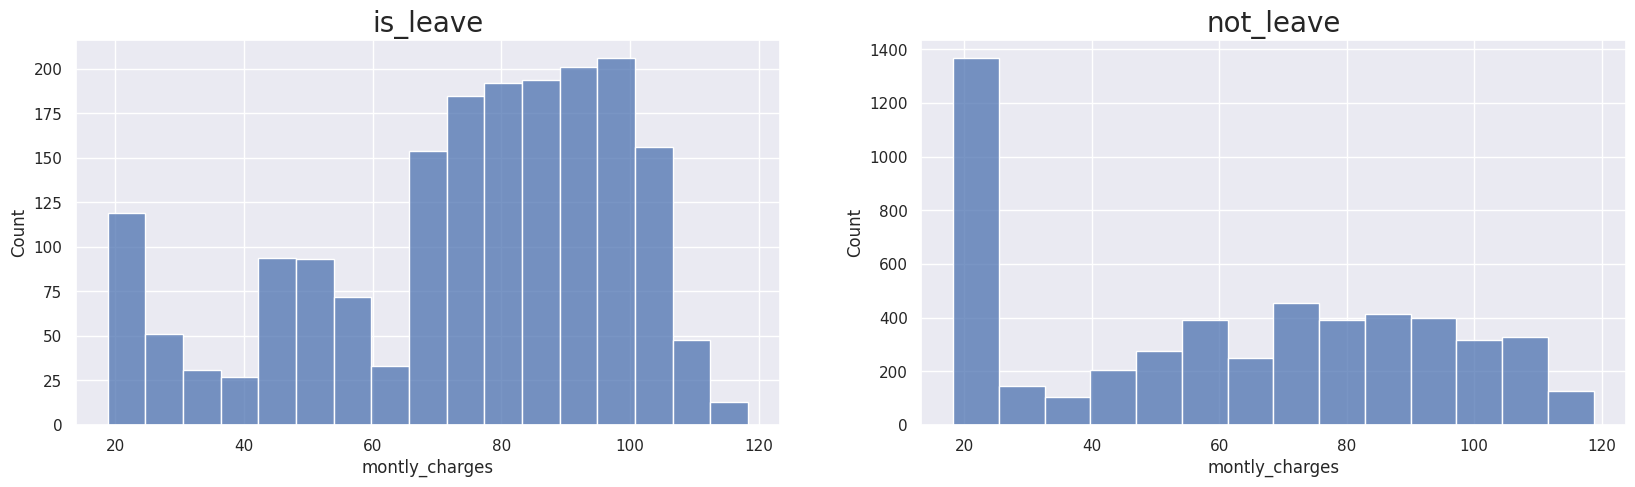

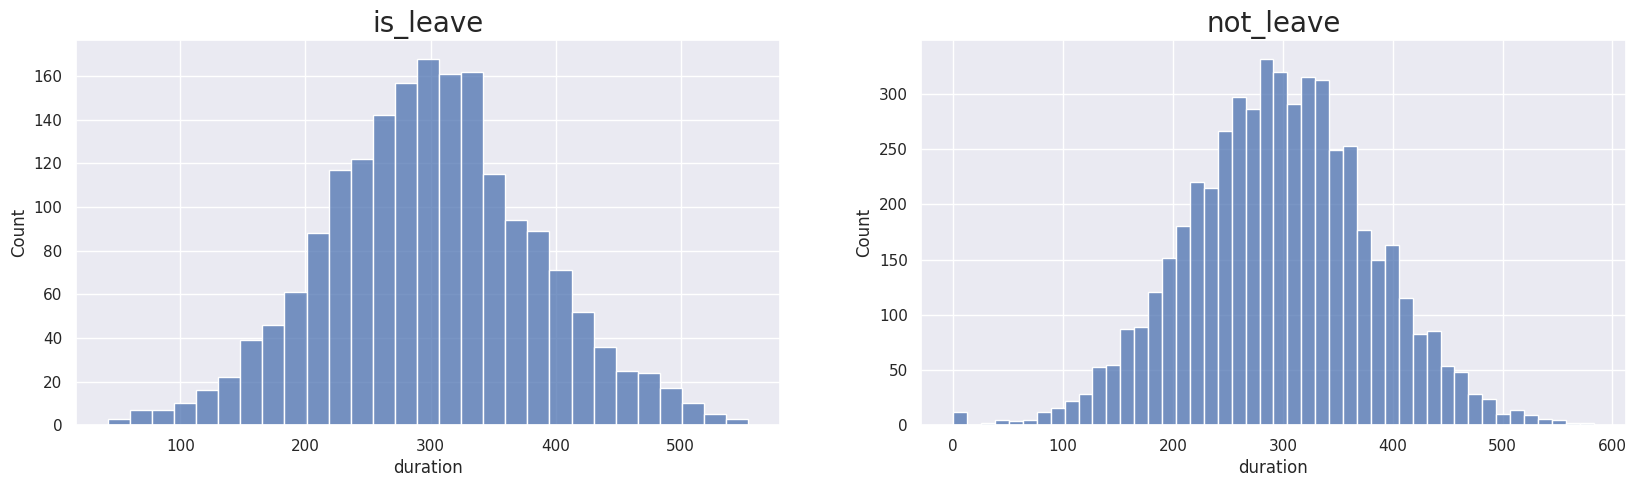

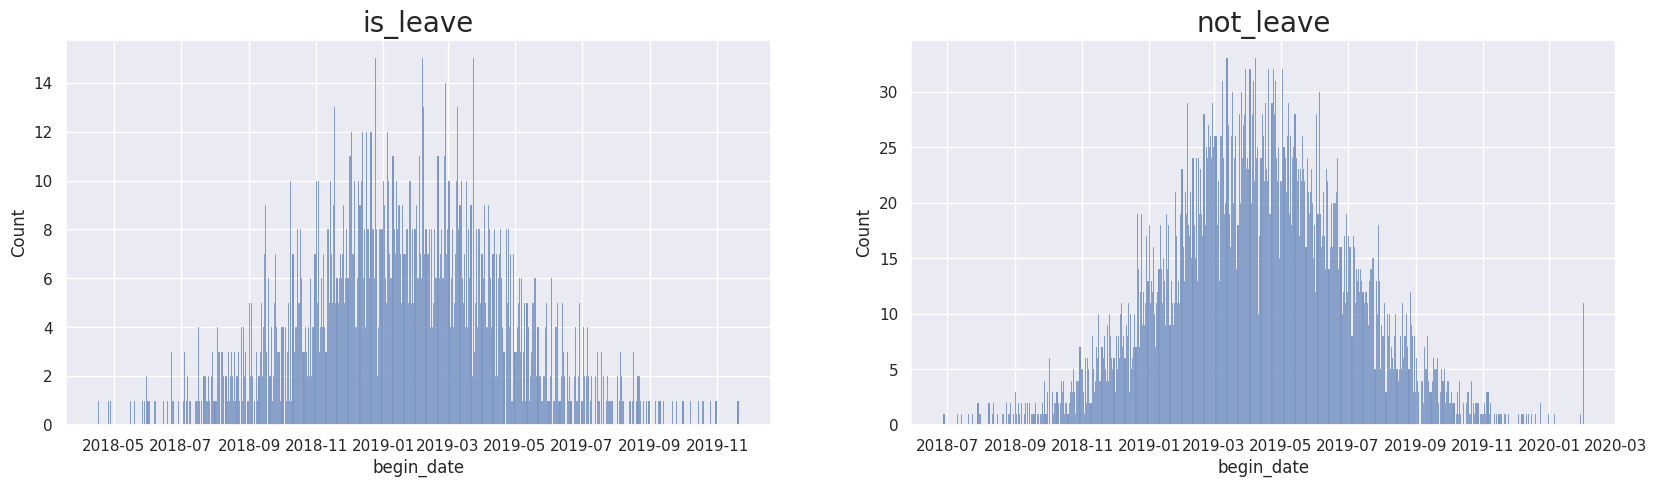

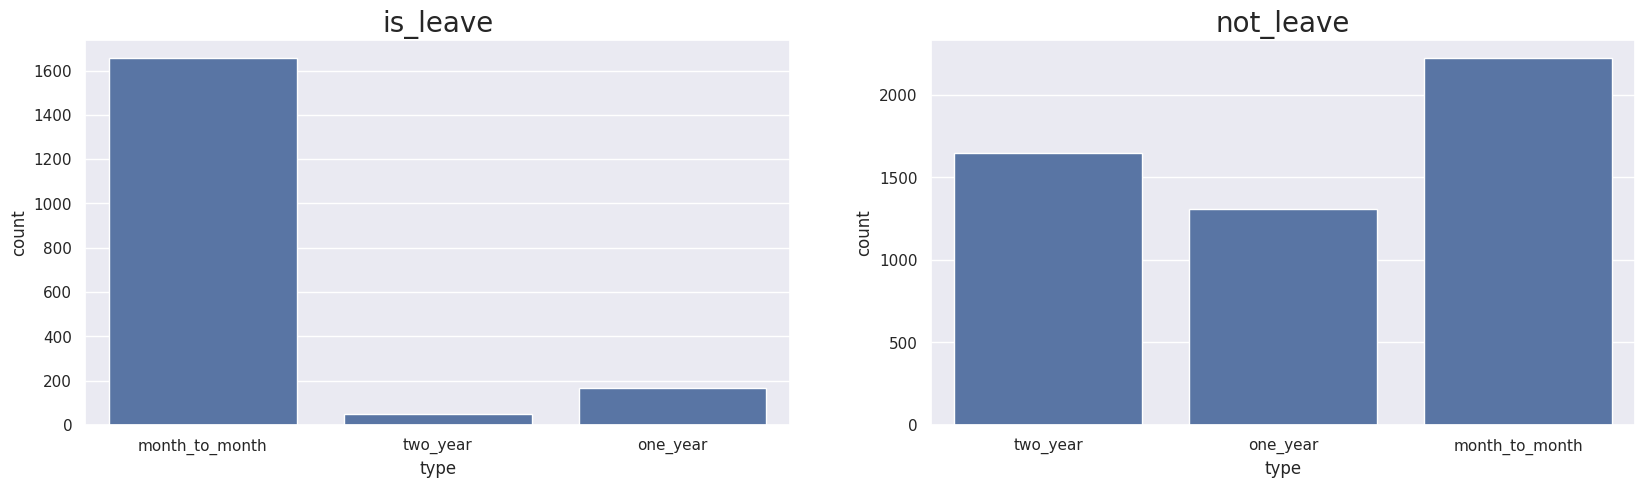

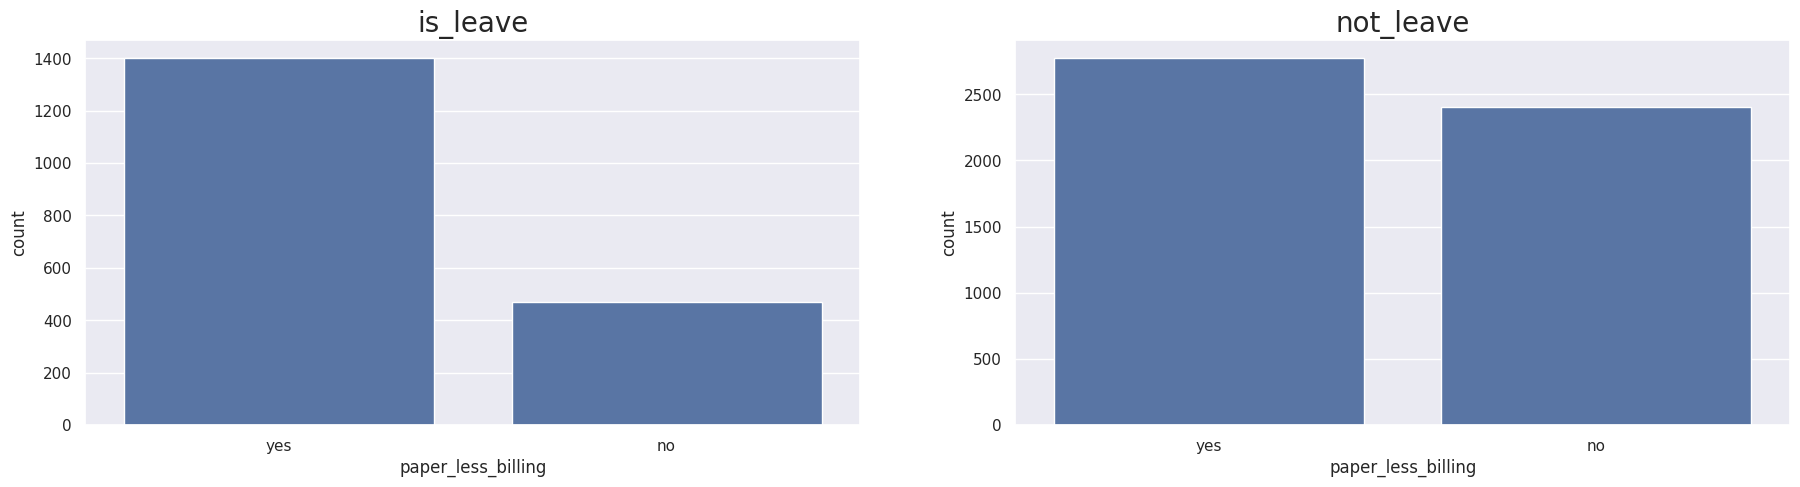

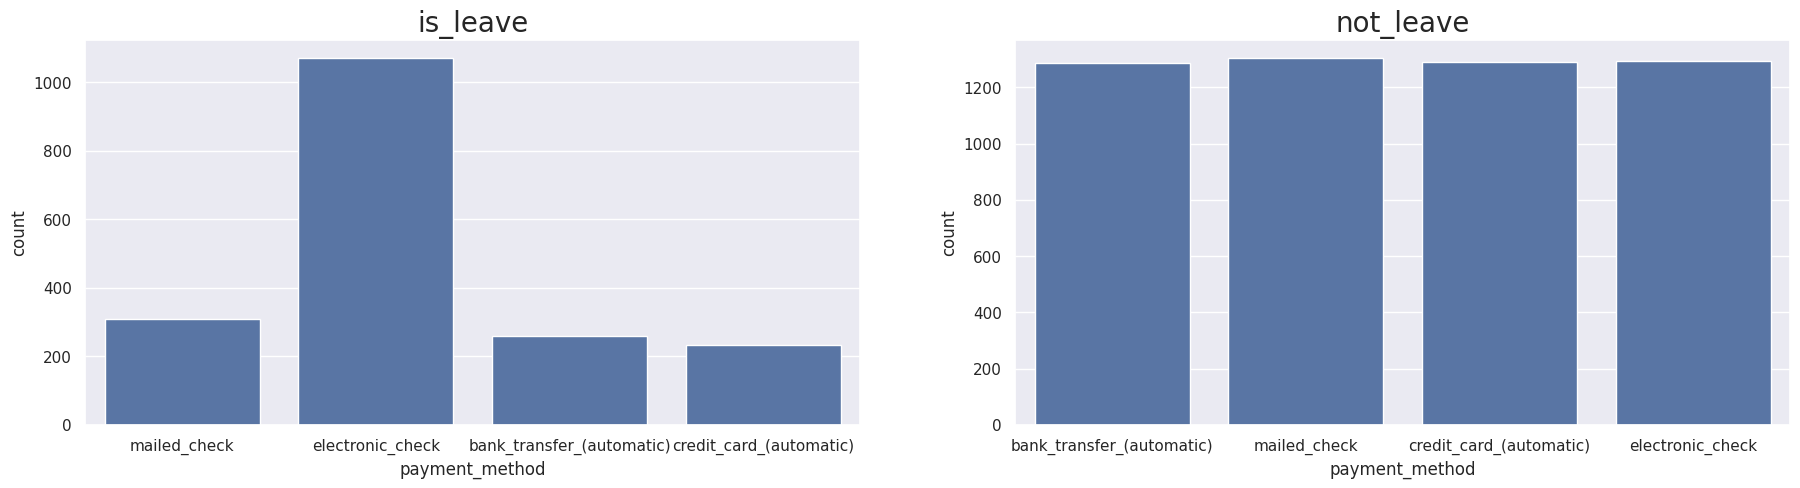

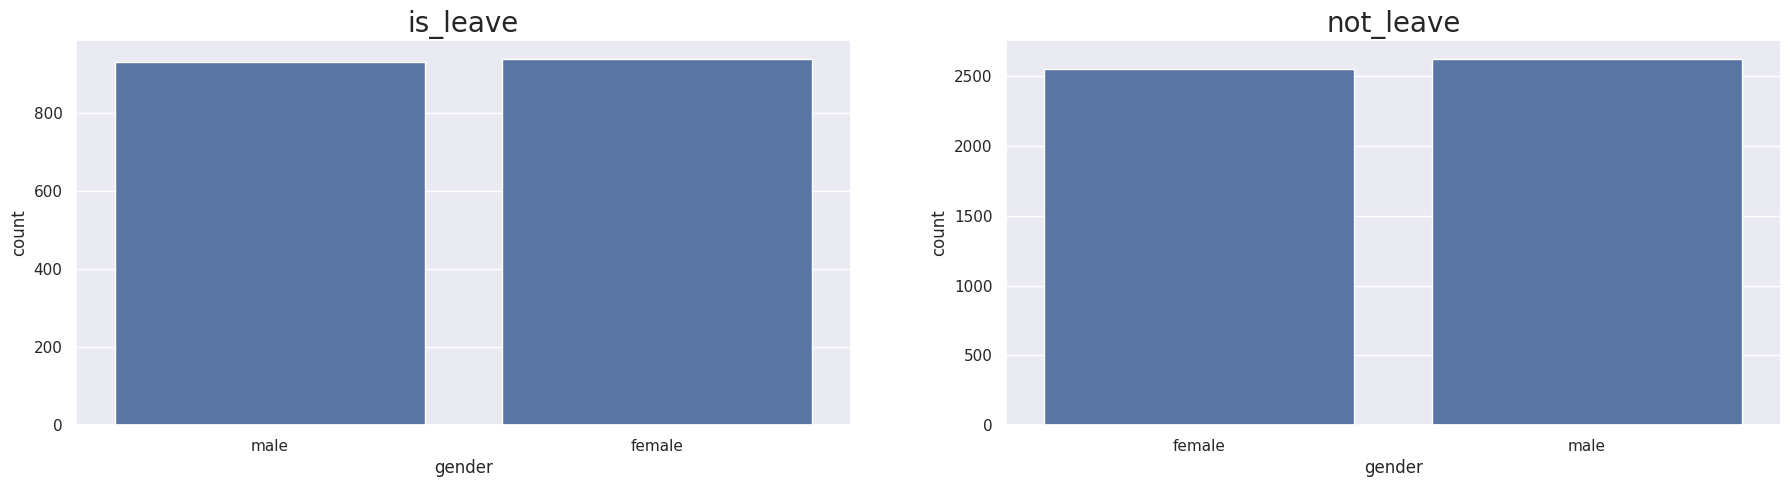

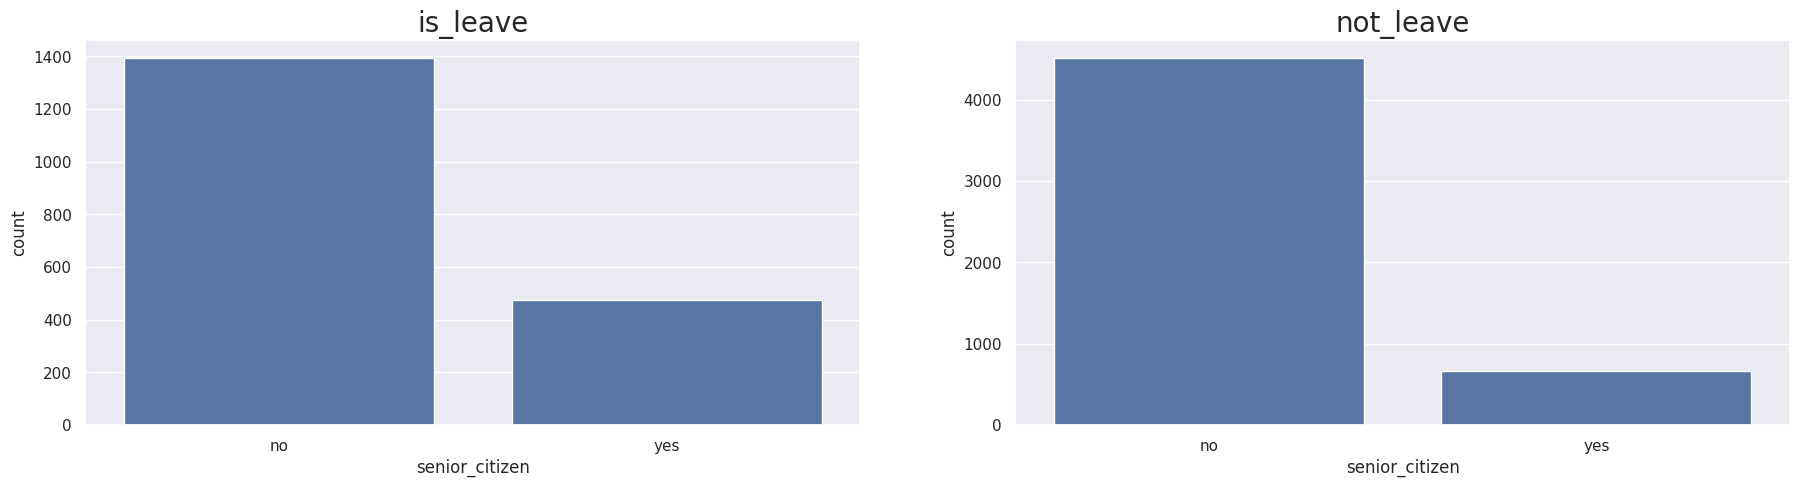

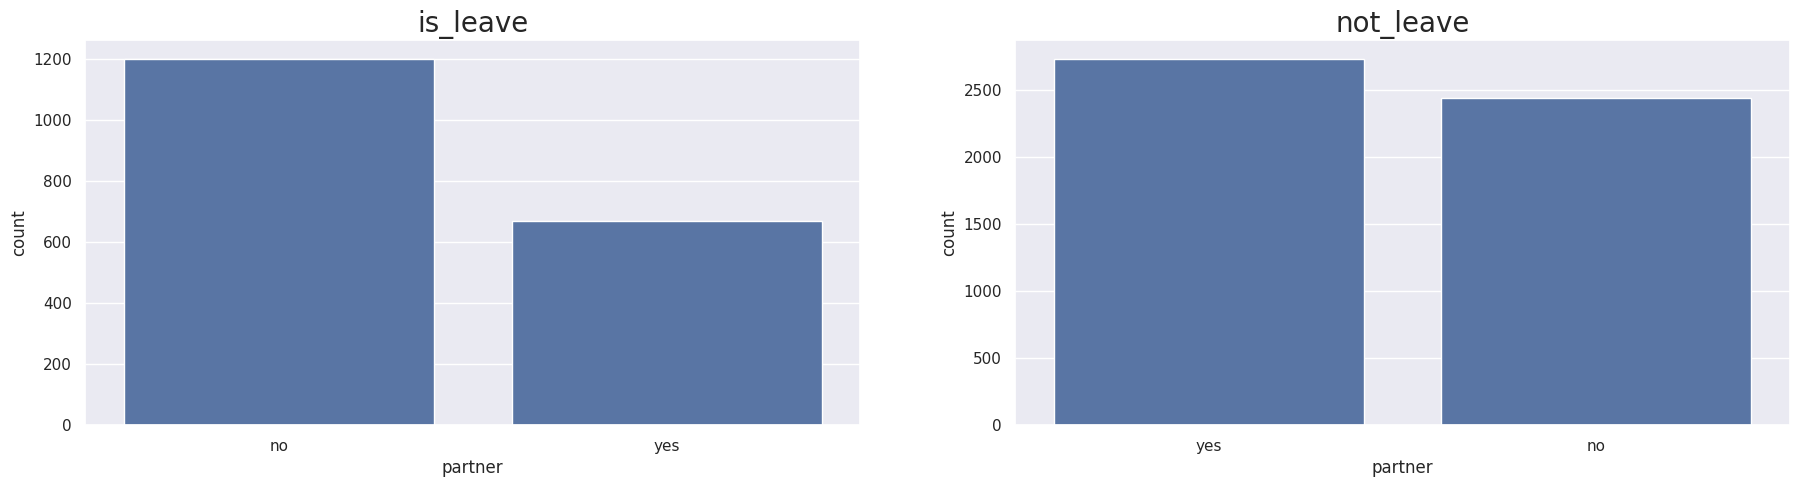

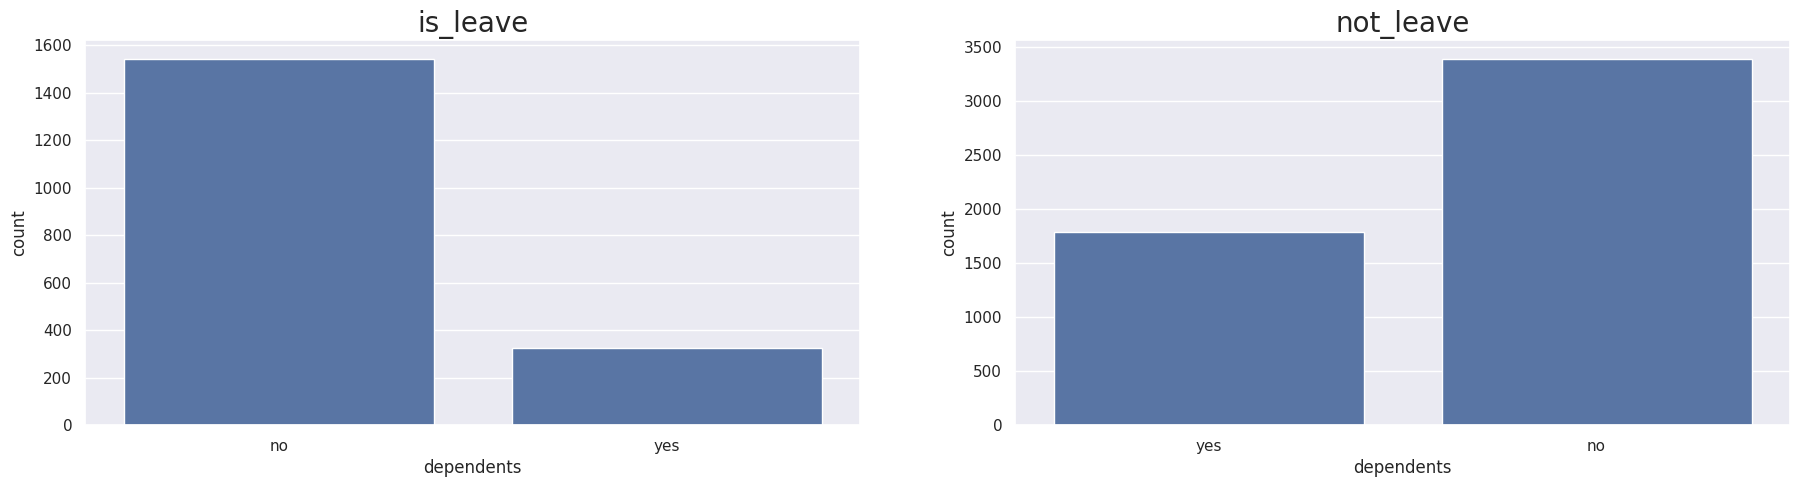

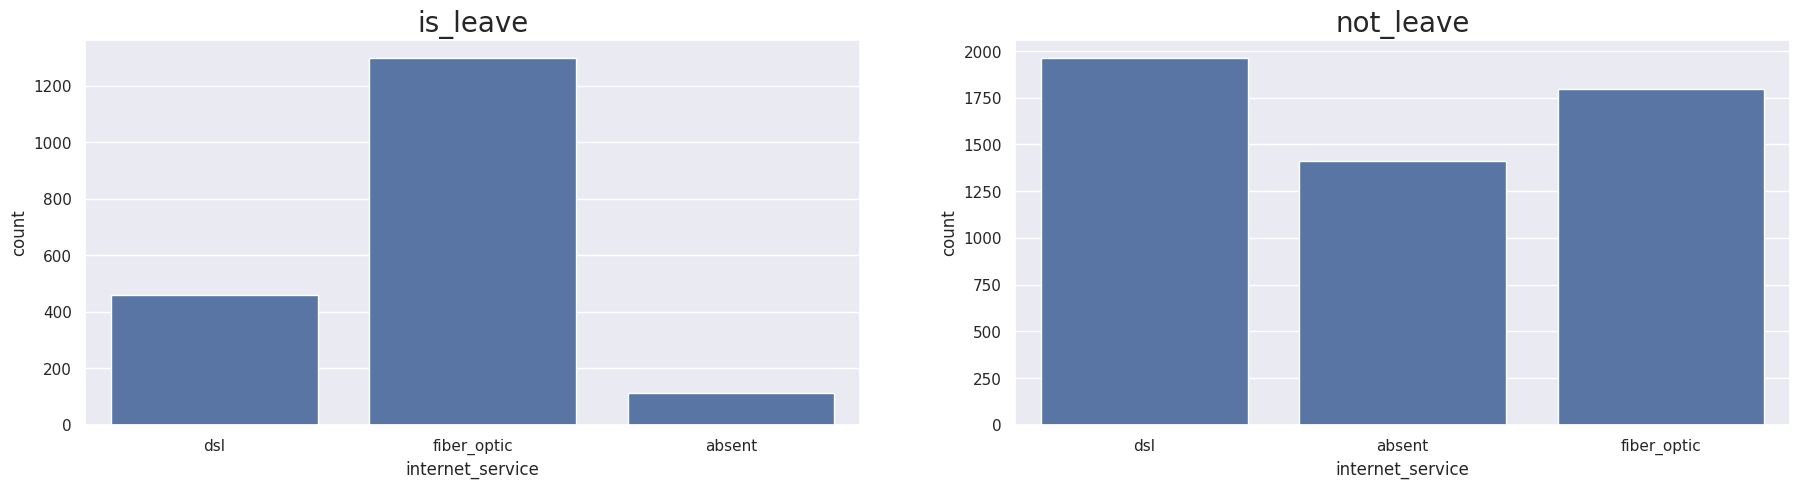

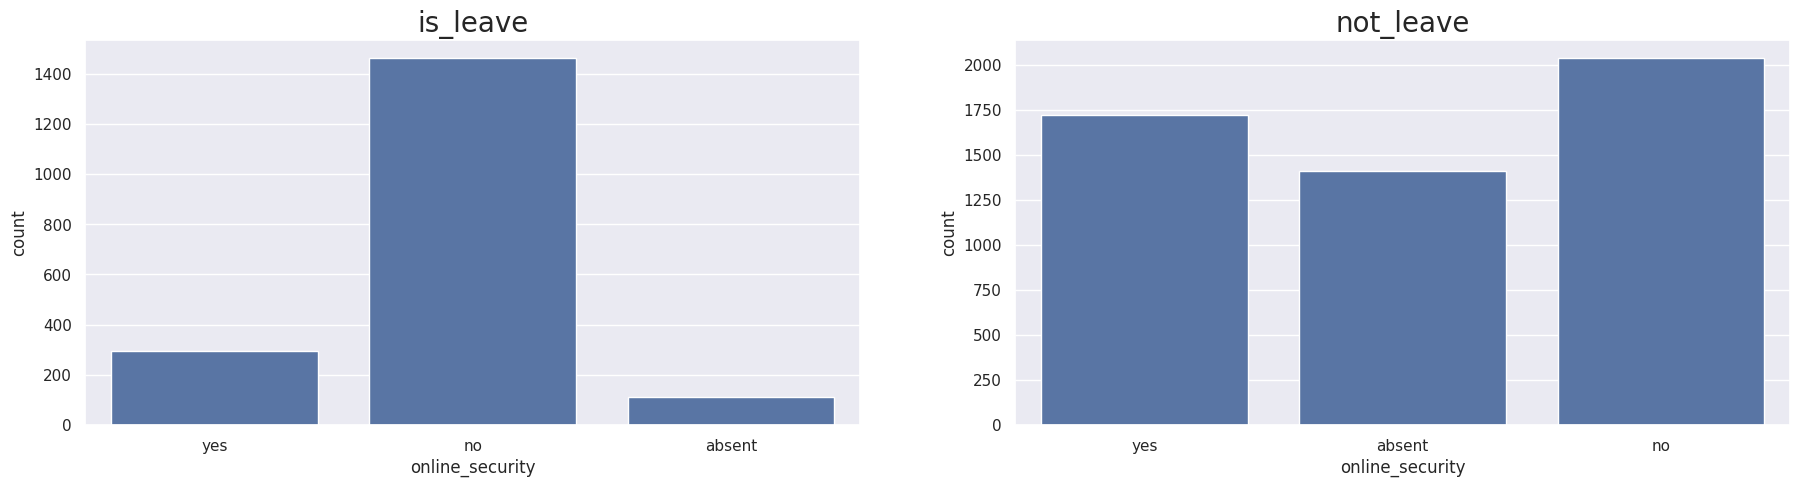

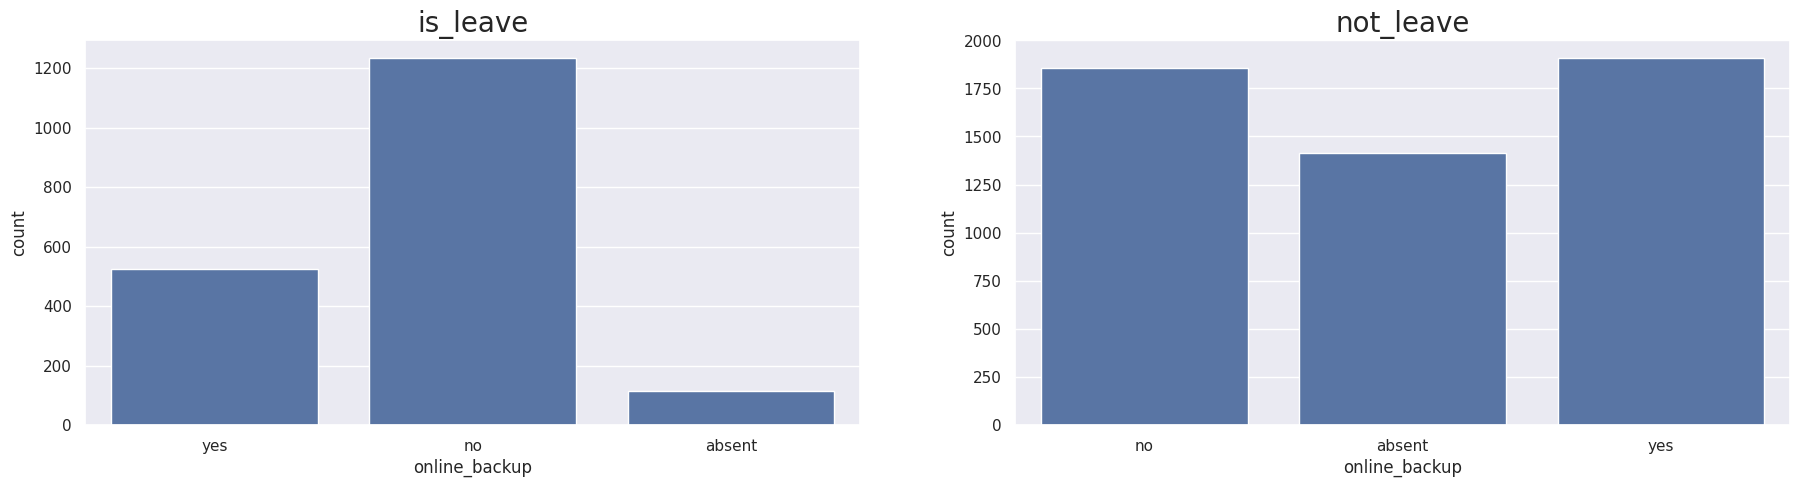

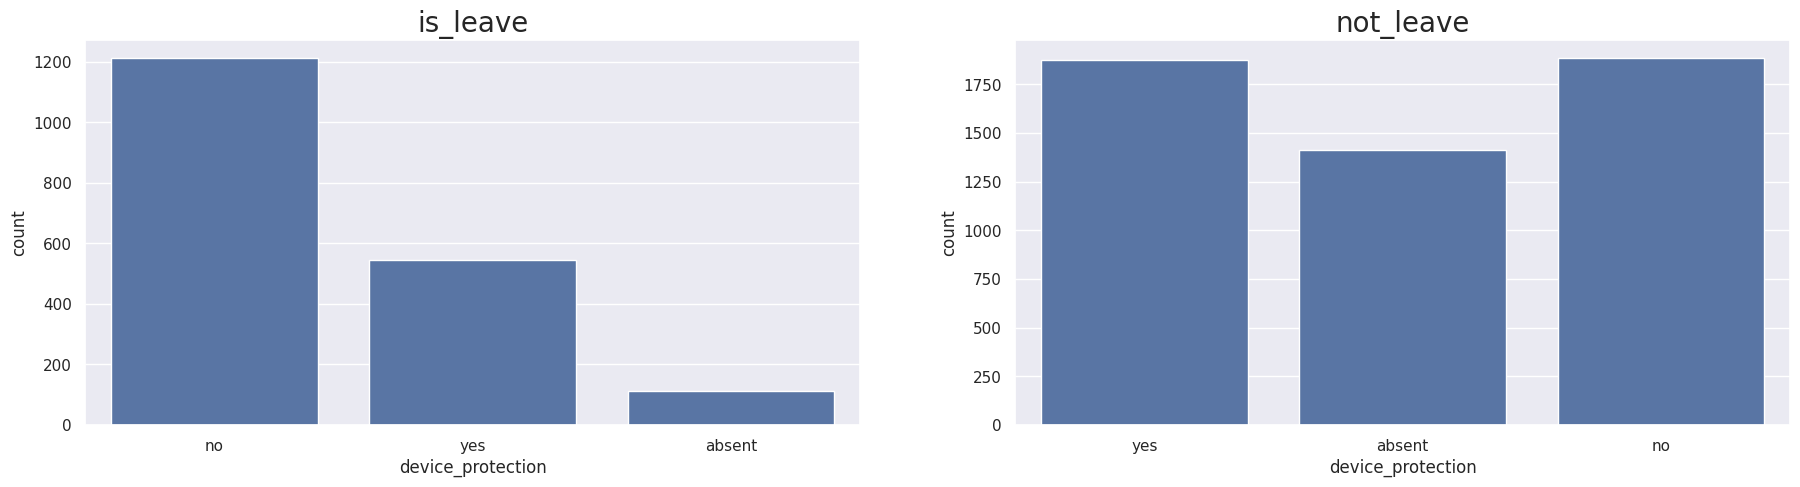

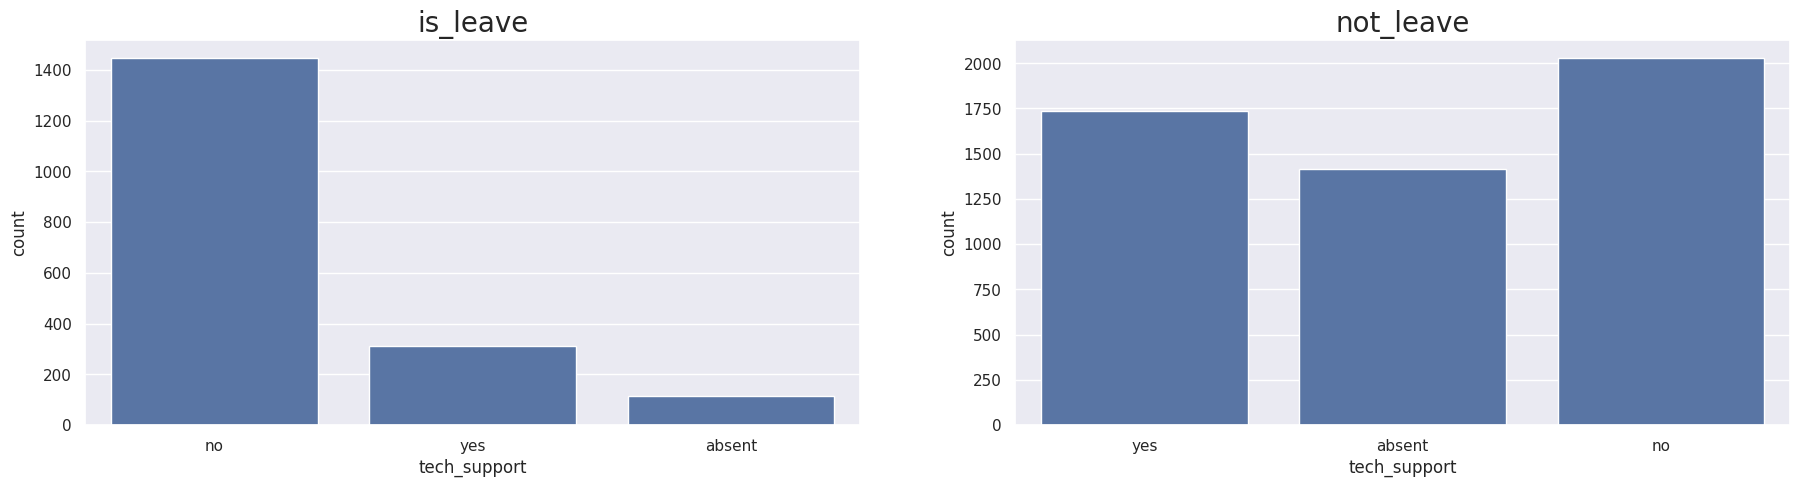

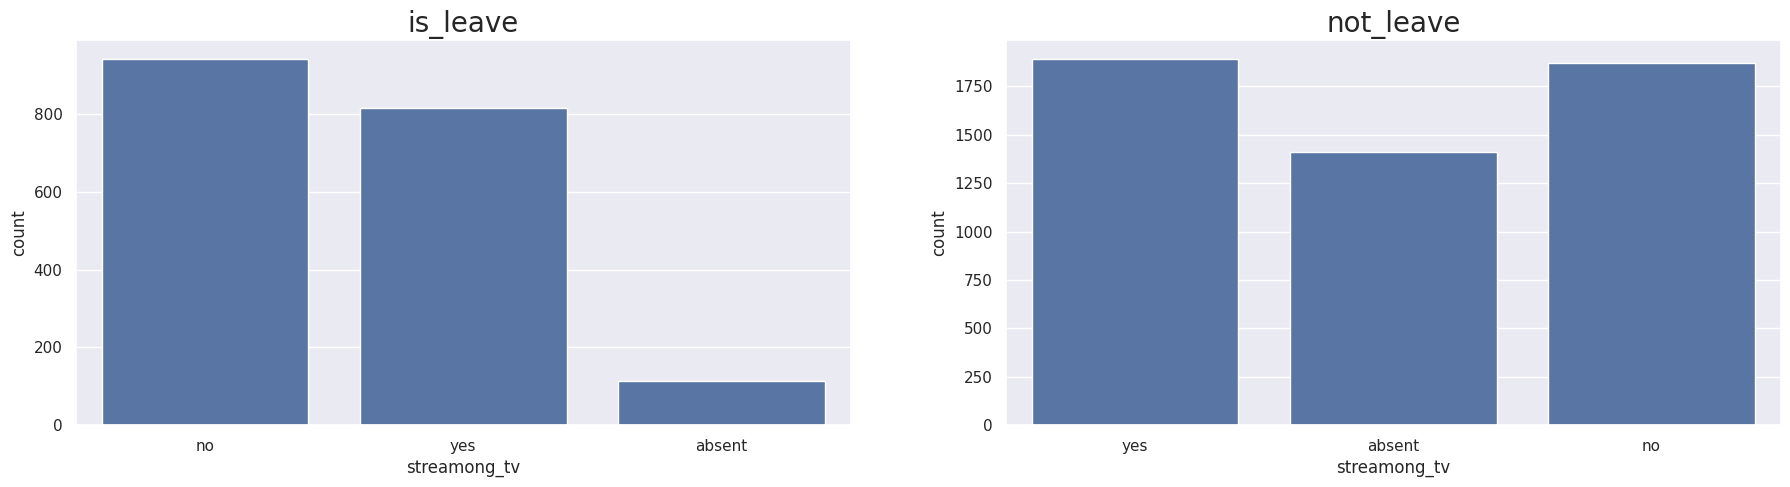

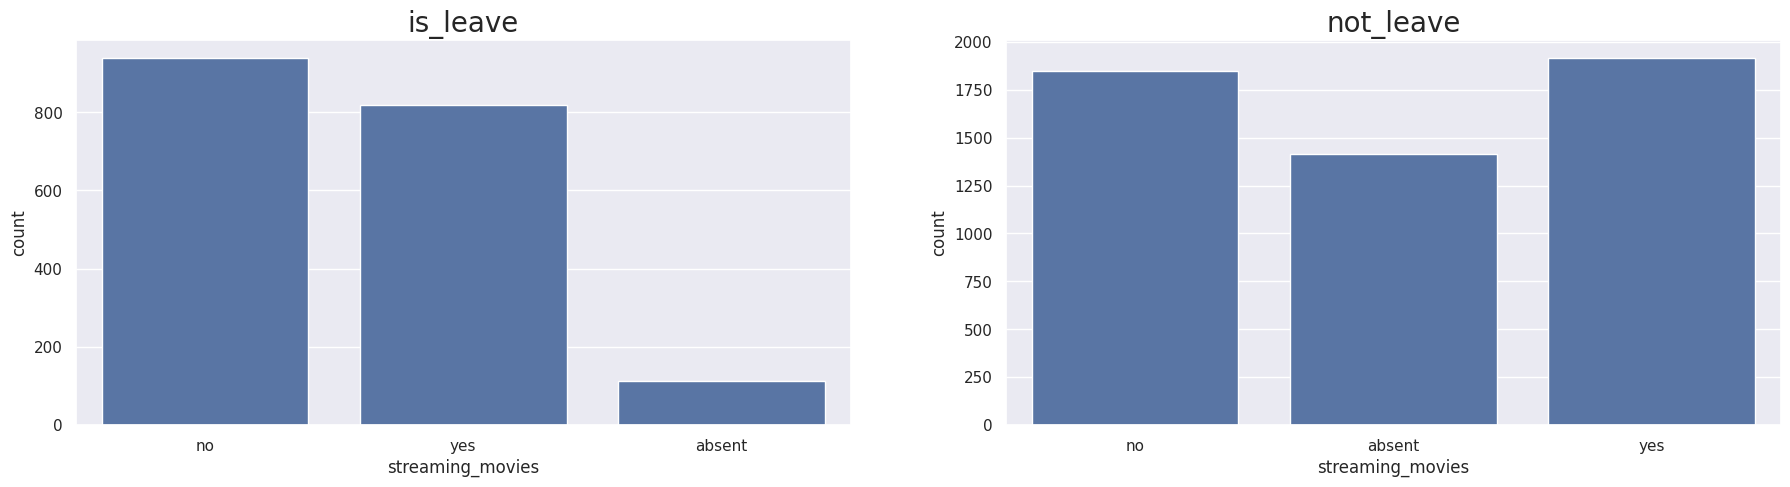

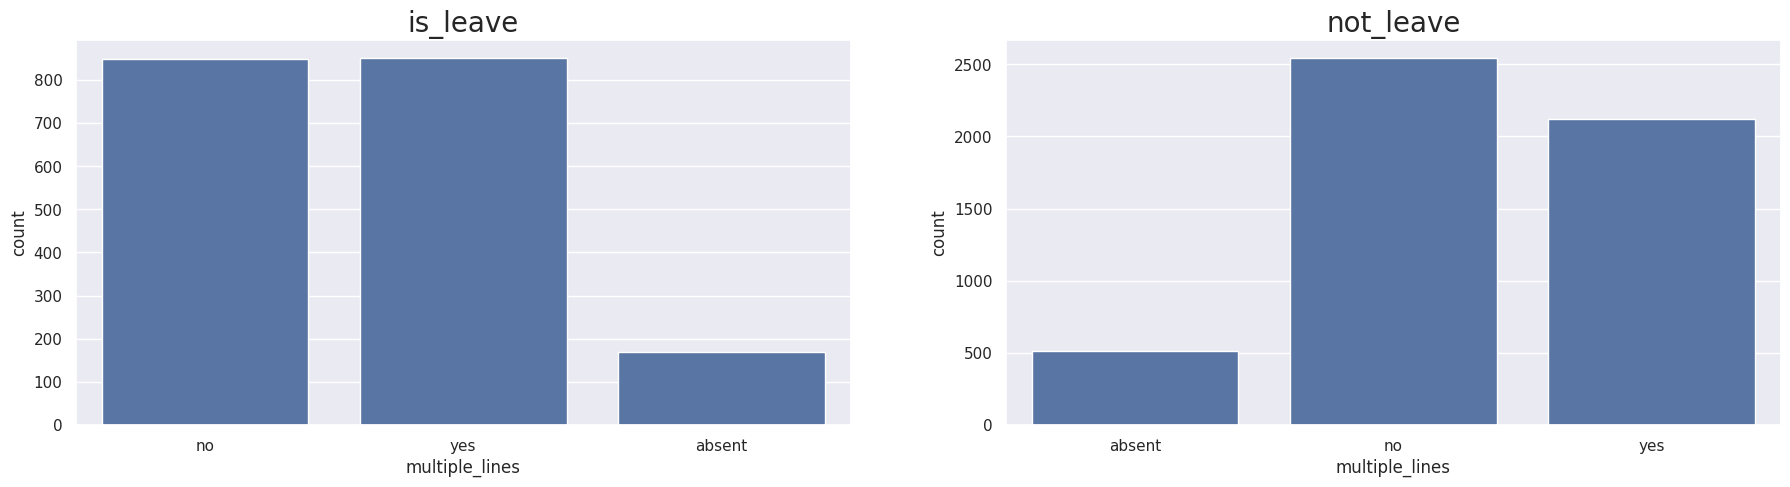

In [103]:
visual_analysis(is_leave, not_leave, cols = num_columns , figsize=(20, 5), is_cat=False)
visual_analysis(is_leave, not_leave, cols = cat_cols , figsize=(22, 5), is_cat=True)

1. Те, кто уходил, сильно чаще  имели оплату month_to_month, хотя и для тех, кто не ушел это также является самым частым типом оплаты. Также ушедшие чаще имели paper_is_billing, не имели online_security, online_backup, device_protection, tech_suppurt, internet_services - fiber_topic и тип оплаты electronic_check, так же не имели партнера в partner. по сравнения с неушедшими клиентами.Также неушедшие клиенты как правило не имели услуги связанные с интернетом то есть, чаще, чем ушедшие клиенты имели значение absent
2. montly_charges имeeт разные формы распределения для ушедших и не ушедших клиентов, что может говорит и наличие зависимости между этими признаками и тем, уйдет ли клиент или нет

3. Остальные признаки имеют одинаковые распределения для у ушедших и неушедших клиентов.Следовательно, эти признаки врят ли имеют взаимосвязь с тем, уйдет ли клиент

# Корреляционный анализ
Для проведения корреляционного анализа буду использовать метод phik, так как в данных много категориальных данных, поэтому кор пирсона использовать нельзя. Так же с помощю кор. Пирсона нельзя исследовать силу зависимости между признакам разных типов данных. Так как признаков много и матрица получится большой 21x 21, то выведу только те пары признаков, которые имеют коэффицент фик выше 0.9

In [104]:
corr_analysis = main_df.drop(['customer_id'], axis=1)

In [105]:
phik_result = corr_analysis.phik_matrix(interval_cols=['total_charges','montly_charges', 'duration'])

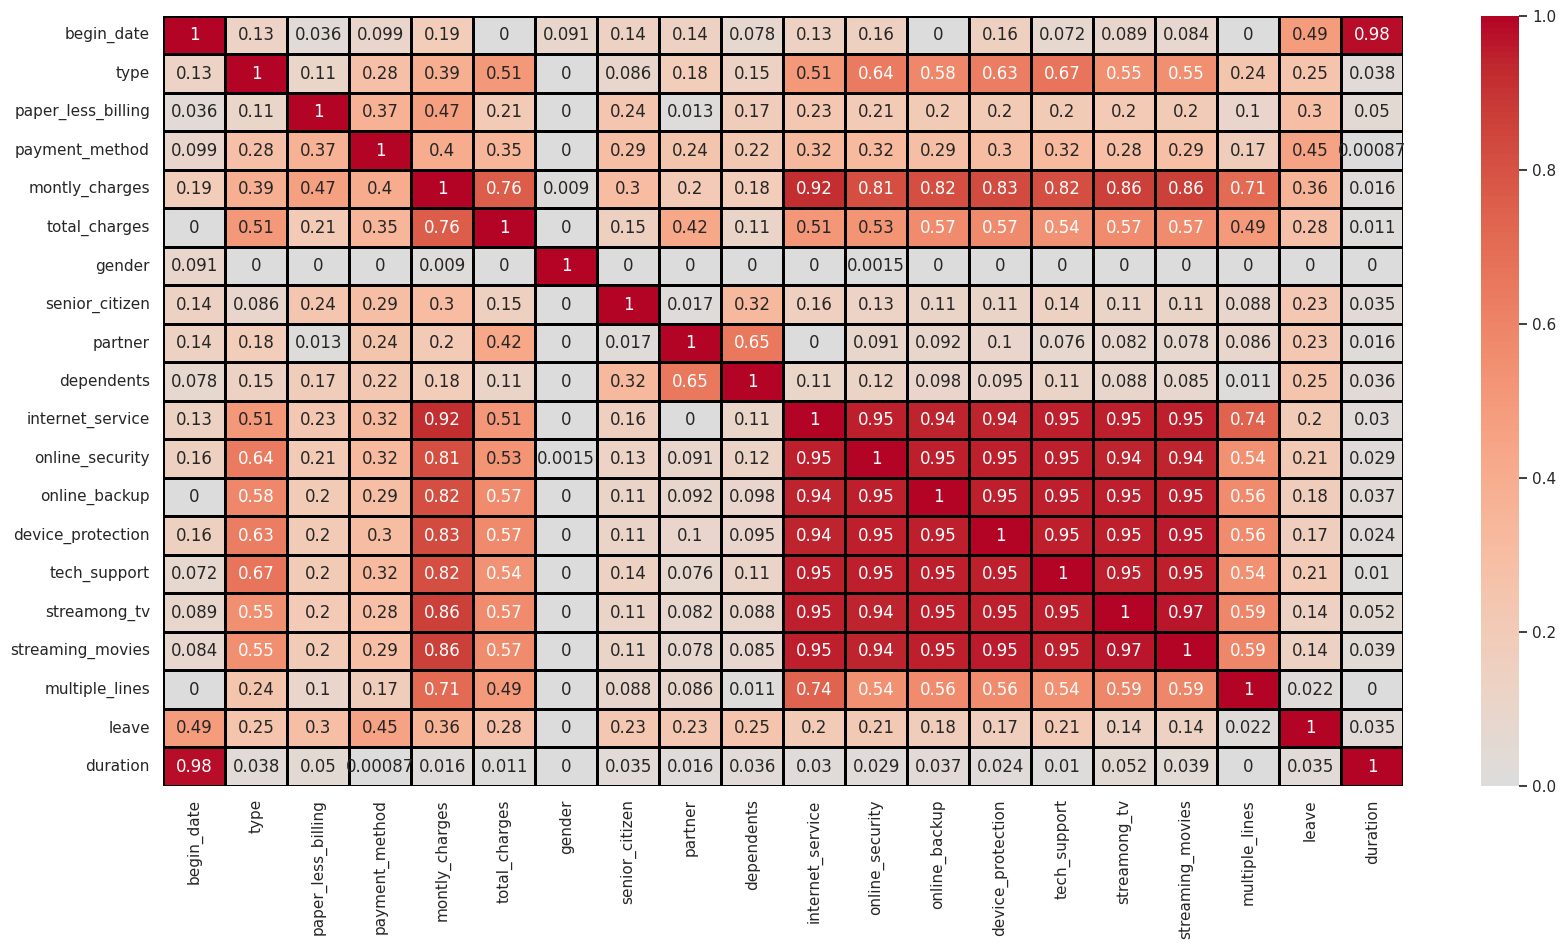

In [106]:
plt.figure(figsize=(20, 10))
sns.heatmap(phik_result, cmap='coolwarm', center=0, annot=True, linewidths=2, linecolor='black');

1. Все интернет услуги между собой имеют выскоий коэфицент фик > 0.9, что означает сильную зависимсоть
2. montly_charges имеет высокий коэфицент фик со всеми данными из таблицы internet, что означает сильную зависимсоть
3. multityple_lines имеет малый коэфицент фик, что означает слабую зависимсоть

# 1.2 Проверка гипотез

### Гипотеза 1

Сумма общих трат отличается в зависимости от типа оплаты. Например, клиенты, которые платят помесячно, тратят меньше, чем клиенты, которые платят раз в год или два

In [107]:
hyp_1 = main_df[['type', 'total_charges']]

In [108]:
one_year = hyp_1[hyp_1['type'] == 'one_year']['total_charges']
two_year = hyp_1[hyp_1['type'] == 'two_year']['total_charges']
month_to_month = hyp_1[hyp_1['type'] == 'month_to_month']['total_charges']

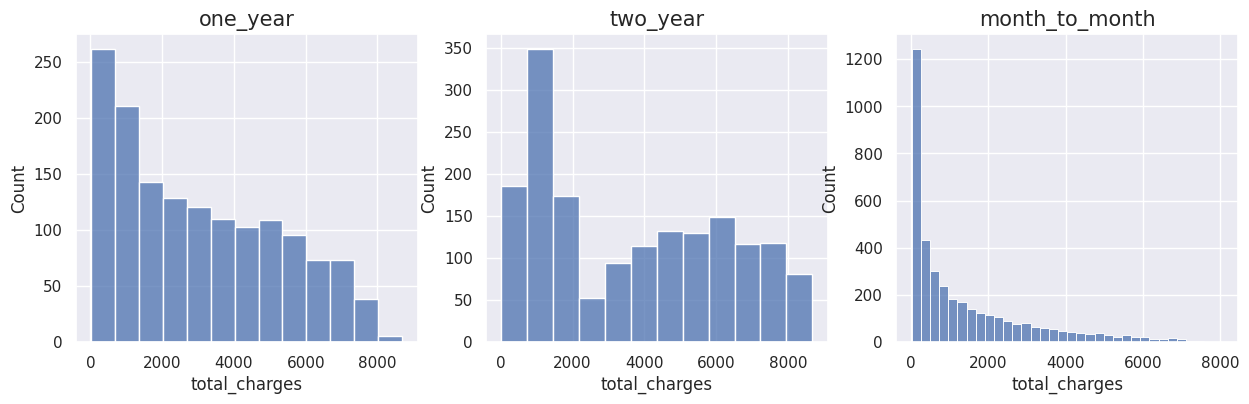

In [109]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
data = [one_year, two_year, month_to_month]
names = ['one_year', 'two_year', 'month_to_month']

for i in range(len(data)):
    ax = plt.subplot(1, 3, i + 1)
    sns.set(rc={'figure.figsize':(15, 5)})
    sns.histplot(data[i])
    plt.title(names[i], fontsize=15)

In [110]:
hyp_1.groupby(by='type').median()

,total_charges
type,
month_to_month,679.55
one_year,2656.70
two_year,3593.80


Видно, клиенты, которые плятят помесячно тратят примерно в 4 раза меньше, чем клиенты платящие раз или в два года - медианное значение 679. Что бы проверить статистическую значисость отклонений и так как данные не распределены нормально и выборки имеют разные размеры, то проведу тест Краскела-Уоллиса о равенстве медиан в нескольких группах, на уровне значимости 0.05

Тест Крускела-Уоллиса<br>
H0 -  Медиана одинакова для всех групп<br>
H1 - Медиана не одинакова для всех групп<br>

In [111]:
p_value = kruskal(one_year, two_year, month_to_month)[1]
if p_value < 0.05:
    print('p_value = ', p_value, 'НЕ доастаточно основания для принятия Н0')
else:
    print('p_value = ', p_value, 'доастаточно основания для принятия Н0')

p_value =  0.0 НЕ доастаточно основания для принятия Н0


так как p value < 0.05, то у нас не достаточно оснований принять гипотезу о равенстве медианных значений в трех группах.

### Вывод


Медианное значение трат за все время у людей, которые платят помесячно в примерно в 4 раза меньше, чем люди платящие один или два раза в год. Медианное значение равно 679.55 против 2656 и 3593. Проведя статистический тест на равность медианных значений в 3 разных группах, имелось достаточно оснований для принятия гипотезы о том, что разница в мединах в тратах в 3 разных группах, статистически значима, следовательно имеется <b> достаточно оснований предполгать, что сумма общих трат отличается в зависимости от типа оплаты</b>. Также имеется закономерность, что чем дольше срок оплаты, тем больше клиент тратит.<br>
<b> ИТОГ: ПОДТВЕРЖДЕНО<b>

## Гипотеза 2
Клиенты, которые оформили подписку в периуд с 2018-10 по 2019-07 сильно чаще брали помесячную оплату, что говорит о том что они скорее всего были менее заинтересованы в услугах

In [112]:
hyp_2 = main_df[['begin_date', 'type']]

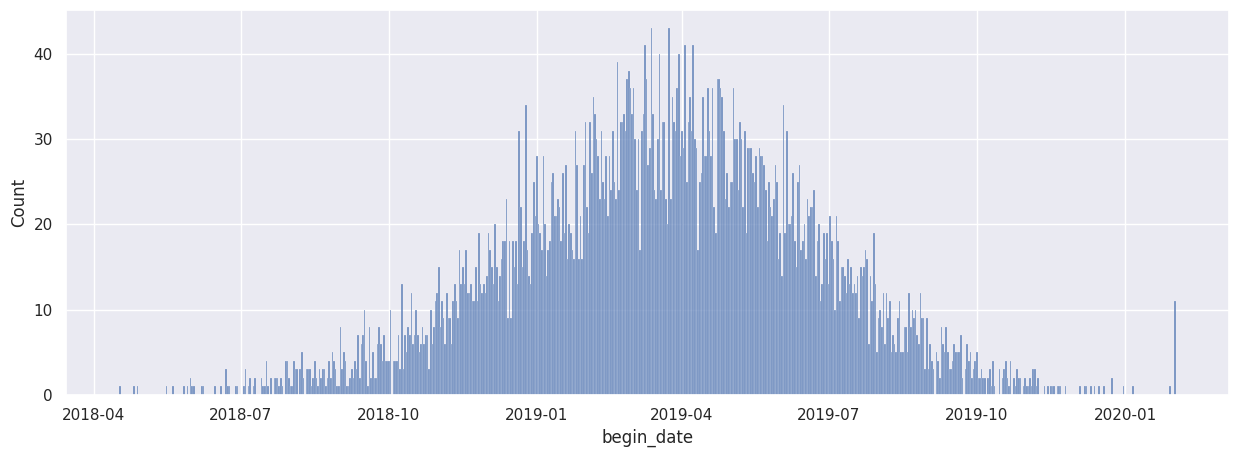

In [113]:
sns.histplot(hyp_2['begin_date']);

In [114]:
group_1 = hyp_2[(hyp_2['begin_date'] >= pd.to_datetime('2018-10'))# клиенты с 2018-10 по 2019-10
                & (hyp_2['begin_date'] <= pd.to_datetime('2019-07'))]

group_2 = hyp_2[(hyp_2['begin_date'] <= pd.to_datetime('2018-10'))
                | (hyp_2['begin_date'] >= pd.to_datetime('2019-07'))]

Распределение типа оплаты у клиентов пришедших с 2018-10 по 2019-07

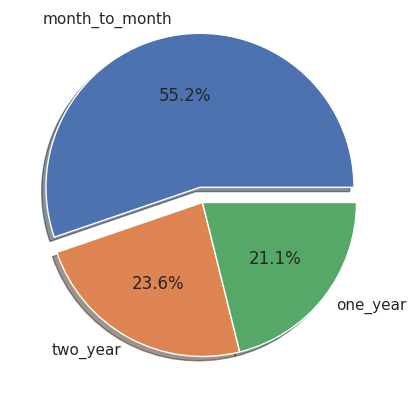

In [115]:
type_precent_1 = group_1['type'].value_counts().values
type_labels_1 = group_1['type'].value_counts().index
plt.pie(type_precent_1, labels=type_labels_1, autopct='%1.1f%%', shadow=True, explode = (0.1, 0, 0));

Распределение типа оплаты у остальных клиентов

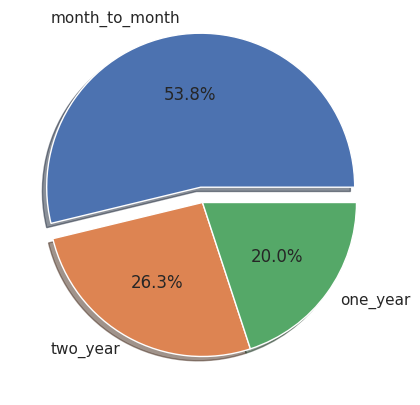

In [116]:
type_precent_2 = group_2['type'].value_counts().values
type_labels_2 = group_2['type'].value_counts().index
plt.pie(type_precent_2, labels=type_labels_2, autopct='%1.1f%%', shadow=True, explode = (0.1, 0, 0));

### Вывод
Распределение Процентных соотношений типов оплаты у клиентов которые пришли в периуд с 2018-10 по 2019-07 имеет небольшое различие с саспределением клиентов пришедших в остальное время. Отсюда можно сделать вывод, что люди пришедшие в пириуд сильного роста пользователей чуть активнее использовали услуги и были  заинтересованы в использовании сервиса 55% и 54% соответсвенно. Отсюда можно сделать вывод, что клиенты, которые оформили подписку в периуд с 2018-10 по 2019-07 не брали чаще помесячную оплату, что говорит о том что они скорее всего не были менее заинтересованы в услугах <br>
<b> ИТОГ: ОПРОВЕРГНУТО <b>

# Подготовка признаков

Для обучения буду использовать все признаки кроме customer_id, begin_date и end_date, так как вместо низ будет использоваться признак duration. В качестве целевой переменной будет признак leave.

In [117]:
main_df = main_df.drop(['customer_id', 'begin_date'], axis=1)

In [118]:
X = main_df.drop(['leave'], axis=1)
Y = main_df['leave']

In [119]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=RANDOM_STATE)

In [120]:
Y_train.value_counts()

0    3872
1    1410
Name: leave, dtype: int64

Имеется сильный дисбаланс классов, поэтому буду использовать веса для каждого класса

In [121]:
class_weights = compute_class_weight(class_weight = 'balanced',
                                     classes = np.unique(Y_train),
                                     y = Y_train)
class_weights = dict(enumerate(class_weights))

In [122]:
class_weights

{0: 0.6820764462809917, 1: 1.873049645390071}

In [123]:
ohe = OneHotEncoder(handle_unknown='ignore', drop = 'first')

In [124]:
std_scaler = StandardScaler()
ord_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',  unknown_value=-1)

In [125]:
num_pipeline = Pipeline([('scaler', std_scaler)])
ohe_cat_pipeline = Pipeline([('ohe', ohe)])
ord_cat_pipeline= Pipeline([('ord', ord_encoder)])

In [126]:
ohe_col_transformer = ColumnTransformer(transformers = [('num_', num_pipeline,
                                        [col for col in X.columns if X[col].dtype != 'object']),

                                        ('cat_', ohe_cat_pipeline,
                                         [col for col in X.columns if X[col].dtype == 'object'])])

In [127]:
ord_col_transformer = ColumnTransformer(transformers =
                        [('num_', num_pipeline,
                         [col for col in X.columns if X[col].dtype != 'object']),

                         ('cat_', ord_cat_pipeline,
                          [col for col in X.columns if X[col].dtype == 'object'])])

In [128]:
ohe_X_train = ohe_col_transformer.fit_transform(X_train)
ohe_X_train = pd.DataFrame(ohe_X_train, columns = ohe_col_transformer.get_feature_names_out())

ohe_X_test = pd.DataFrame(ohe_col_transformer.transform(X_test),
                       columns = ohe_col_transformer.get_feature_names_out())

In [129]:
ord_X_train = ord_col_transformer.fit_transform(X_train)
ord_X_train = pd.DataFrame(ord_X_train, columns = ord_col_transformer.get_feature_names_out())

ord_X_test = pd.DataFrame(ord_col_transformer.transform(X_test),
                       columns = ord_col_transformer.get_feature_names_out())

In [130]:
ohe_X_train.shape

(5282, 29)

In [131]:
Y_train.shape

(5282,)

# Обучение моделей

In [132]:
def select_hyper_params(estimator, params, X_train, Y_train):
    grid_search = RandomizedSearchCV(param_distributions = params,
                           estimator = estimator,
                           scoring = 'roc_auc',
                           n_jobs = -1,
                           cv=5,
                           verbose=1,
                           n_iter = 50,
                           error_score = 'raise',
                           random_state=RANDOM_STATE)

    grid_search.fit(X_train, Y_train)

    return grid_search

## Линейная регрессия

In [133]:
lr_params = {
    'penalty': ['l2', None],
    'C': [1.0, 10.0, 100.0]}

In [134]:
lr_model = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')

In [135]:
lr_grid_search = GridSearchCV(
    estimator = lr_model,
    param_grid = lr_params,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5,
    verbose=0
)

lr_grid_search.fit(ohe_X_train, Y_train);

In [136]:
lr_model = lr_grid_search.best_estimator_

In [137]:
print('best valid ROC_AUC = ', lr_grid_search.best_score_)

best valid ROC_AUC =  0.8327496531343238


## Случайный лес

In [138]:
rf_model = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')

In [139]:
max_depth = list(range (2,7))
n_estimators = list(range(5,100,5))
min_samples_split = list(range(6,50,2))
min_samples_leaf =  list(range(4,50))
ccp_alpha = np.arange(0, 1, 0.05)
criterion = ['gini', 'entropy', 'log_loss']

In [140]:
rf_params = {
    'max_depth': max_depth,
    'n_estimators': n_estimators,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'criterion':criterion,
    'ccp_alpha': ccp_alpha
}

In [141]:
rf_grid_search = select_hyper_params(rf_model, rf_params, ord_X_train, Y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [142]:
print('best valid ROC_AUC = ', rf_grid_search.best_score_)

best valid ROC_AUC =  0.8400881201387819


## Градиентный бустинг

In [143]:
lgbm_model = lgbm.LGBMClassifier(objective='binary',
                                 verbose = -1,
                                 class_weight=class_weights,
                                 random_state = RANDOM_STATE)

In [144]:
lgbm_params = {
    'lgbm__max_depth': max_depth,
    'lgbm__n_estimators': n_estimators,
    'lgbm__min_samples_split': min_samples_split,
    'lgbm__min_samples_leaf': min_samples_leaf,
    'lgbm__criterion':criterion,
    'lgbm__ccp_alpha': ccp_alpha
}

In [145]:
lgbm_grid_search = select_hyper_params(lgbm_model , lgbm_params, ord_X_train, Y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [146]:
print('best valid accuracy = ', lgbm_grid_search.best_score_)

best valid accuracy =  0.8301952935042272


## Voting_classifier

In [147]:
voting_models = VotingClassifier(estimators = [
    ('rf', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')),
    ('lgbm',  lgbm.LGBMClassifier(objective='binary', verbose = -1, class_weight=class_weights, random_state=RANDOM_STATE)),
    ('dtc', DecisionTreeClassifier(random_state = RANDOM_STATE, class_weight='balanced'))
], voting='soft')

In [148]:
voting_params = {
    'rf__max_depth': max_depth,
    'rf__n_estimators': n_estimators,
    'rf__min_samples_split': min_samples_split,
    'rf__min_samples_leaf': min_samples_leaf,
    'rf__criterion':criterion,
    'lgbm__max_depth': max_depth,
    'lgbm__n_estimators': n_estimators,
    'lgbm__min_samples_split': min_samples_split,
    'lgbm__min_samples_leaf': min_samples_leaf,
    'lgbm__criterion':criterion,
    'dtc__max_depth': max_depth,
    'dtc__min_samples_split': min_samples_split,
    'dtc__min_samples_leaf': min_samples_leaf,
    'dtc__criterion':criterion
}

In [149]:
voting_grid_search = select_hyper_params(voting_models, voting_params, ord_X_train, Y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [150]:
print('best_valid ROC_AUC: ', voting_grid_search.best_score_)

best_valid ROC_AUC:  0.8434959366319121


## Полносвязанная нейронная сеть

In [ ]:
def create_model(input_shape, optimizer, count_layers):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(10, input_dim = input_shape, activation = 'relu',
                                 kernel_initializer = keras.initializers.glorot_uniform()))

    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.BatchNormalization())

    for i in range(count_layers):
        model.add(keras.layers.Dense(10, activation='relu'))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer = optimizer,
                  run_eagerly=True,
                  loss = keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

    model.build(input_shape = input_shape)

    return model

In [ ]:
def cross_val_roc_auc(model, X_train, Y_train):
    kf = KFold(n_splits= 5, shuffle=True)
    scores = []
    for train_idx, valid_idx in kf.split(X_train):
        cross_X_train, cross_Y_train = X_train.iloc[train_idx], Y_train.iloc[train_idx]
        cross_X_valid, cross_Y_valid = X_train.iloc[valid_idx], Y_train.iloc[valid_idx]

        NN_model.fit(cross_X_train, cross_Y_train,
                batch_size = 200,
                epochs=100,
                class_weight = class_weights)

        valid_predict = NN_model.predict(cross_X_valid)
        print('valid_roc_auc_score: ', roc_auc_score(cross_Y_valid, valid_predict))
        scores.append(roc_auc_score(cross_Y_valid, valid_predict))

    return sum(scores) / len(scores)

In [ ]:
NN_model = create_model(ohe_X_train.shape[1], keras.optimizers.Adam(learning_rate=0.0001), 3)

In [ ]:
NN_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 10)                240       
                                                                 
 dropout_24 (Dropout)        (None, 10)                0         
                                                                 
 batch_normalization_24 (Ba  (None, 10)                40        
 tchNormalization)                                               
                                                                 
 dense_31 (Dense)            (None, 10)                110       
                                                                 
 dropout_25 (Dropout)        (None, 10)                0         
                                                                 
 batch_normalization_25 (Ba  (None, 10)                40        
 tchNormalization)                                    

In [ ]:
#Y_train = Y_train.astype('float32')

In [ ]:
NN_roc_auc = cross_val_roc_auc(NN_model, ohe_X_train, Y_train)

Epoch 1/100
22/22 [==============================] - 2s 104ms/step - loss: 0.7788 - accuracy: 0.4719
Epoch 2/100
22/22 [==============================] - 2s 87ms/step - loss: 0.7646 - accuracy: 0.4764
Epoch 3/100
22/22 [==============================] - 2s 85ms/step - loss: 0.7567 - accuracy: 0.4790
Epoch 4/100
22/22 [==============================] - 2s 86ms/step - loss: 0.7590 - accuracy: 0.4880
Epoch 5/100
22/22 [==============================] - 2s 86ms/step - loss: 0.7646 - accuracy: 0.4757
Epoch 6/100
22/22 [==============================] - 2s 92ms/step - loss: 0.7586 - accuracy: 0.4845
Epoch 7/100
22/22 [==============================] - 2s 112ms/step - loss: 0.7598 - accuracy: 0.4857
Epoch 8/100
22/22 [==============================] - 2s 94ms/step - loss: 0.7581 - accuracy: 0.4861
Epoch 9/100
22/22 [==============================] - 2s 86ms/step - loss: 0.7481 - accuracy: 0.4921
Epoch 10/100
22/22 [==============================] - 2s 87ms/step - loss: 0.7570 - accuracy: 0.48

In [ ]:
print('valid_roc_auc_score: ', NN_roc_auc)

valid_roc_auc_score:  0.8045674529581556


# Тестирования модели

In [ ]:
def ROC_AUC_plot(X_test, Y_test, final_model):
    scores = final_model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test, scores)

    plt.figure(figsize = (4, 4))
    plt.grid(True)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    sns.lineplot(x = fpr, y = tpr)

    print('ROC_AUC = ', round(roc_auc_score(Y_test, scores), 3))

In [ ]:
def precision_recall_plot(X_test, Y_test, final_model):
    scores = final_model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(Y_test, scores)

    plt.figure(figsize=(4, 4))
    plt.grid(True)
    plt.xlabel('precision')
    plt.ylabel('recall')
    sns.lineplot(x = precision, y = recall)

In [ ]:
final_model = voting_grid_search.best_estimator_

In [ ]:
test_predict = final_model.predict(ord_X_test)

In [ ]:
print('test_accuracy: ', accuracy_score(Y_test, test_predict))
print('test_f1_score: ', f1_score(Y_test, test_predict))

test_accuracy:  0.747870528109029
test_f1_score:  0.6243654822335025


## ROC_AUC

ROC_AUC =  0.85


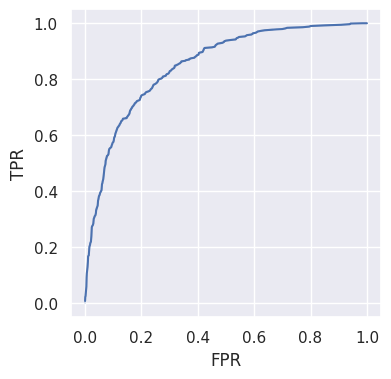

In [ ]:
ROC_AUC_plot(ord_X_test, Y_test, final_model)

## precision and recall

In [ ]:
conf_matrix = pd.DataFrame(confusion_matrix(Y_test, test_predict))

In [ ]:
print('precision_score: ', precision_score(test_predict, Y_test))
print('recall_score: ', recall_score(test_predict, Y_test))

precision_score:  0.803921568627451
recall_score:  0.5103734439834025


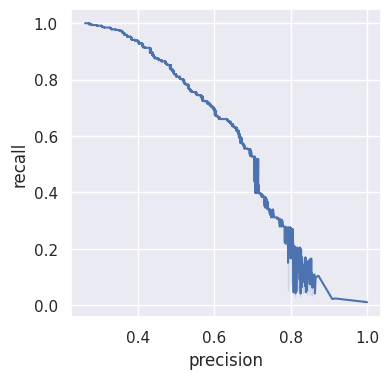

In [ ]:
precision_recall_plot(ord_X_test, Y_test, final_model)

Значение метрики precision = 0.8 означает, что 80% из тех клиентов, которых модель опредлила, как ушедших клиентов, действительно были ушедшими клиентами. recall = 0.8. Значение метрики recall = 0.51 означает, то что модель, что модель обнаруживает около 51% всех ушедших клиентов.

## confusion_matrix

In [ ]:
conf_matrix

,0,1
0,948,354
1,90,369


- Модель верно предсказывает уход клиентов в 369 случаях (TP).
- Модель ошибочно предсказывает уход клиентов в 354 случаях (FP), что может привести к ненужным затратам на удержание этих клиентов.
- Модель правильно предсказывает оставшихся клиентов в 948 случаях (TN).
- Но также модель ошибочно предсказывает, что клиенты остаются в 90 случаях (FN), что может привести к потере дохода от ушедших клиентов.

# Анализ важности признаков

In [ ]:
def get_feature_importances(model):
    feature_importances = []
    for estimator in final_model.estimators_:
        if hasattr(estimator, 'feature_importances_'):
            feature_importances.append(estimator.feature_importances_)

    return np.mean(feature_importances, axis=0)

In [ ]:
feature_importances = pd.DataFrame({
    'feauters': ord_X_train.columns,
    'importances_coef': get_feature_importances(final_model)
})
feature_importances.sort_values('importances_coef', ascending=False)

,feauters,importances_coef
1,num___total_charges,49.421654
0,num___montly_charges,30.706306
2,num___duration,25.005803
3,cat___type,15.677165
10,cat___internet_service,11.748095
5,cat___payment_method,10.344436
17,cat___multiple_lines,7.002736
11,cat___online_security,4.355801
4,cat___paper_less_billing,4.337085
15,cat___streamong_tv,4.010476


### Вывод

Тремя самыми влияющим признакоми оказались total_cahrges, duration, montly_charges. Total_charges имеет коэффицент 49, после него идет признак montly_charges = 30  и duration = 25 - длительность контракта. В исследовательском анализе было видно, что этот признак montly_charges имеет разные распределения среди ушедших и не ушедших клиентов.

# Анализ total_charges и целевой переменной

In [ ]:
analysis_data = main_df[['total_charges', 'leave']]

In [ ]:
leave_group = analysis_data[analysis_data['leave'] == 1]
not_leave_group = analysis_data[analysis_data['leave'] == 0]

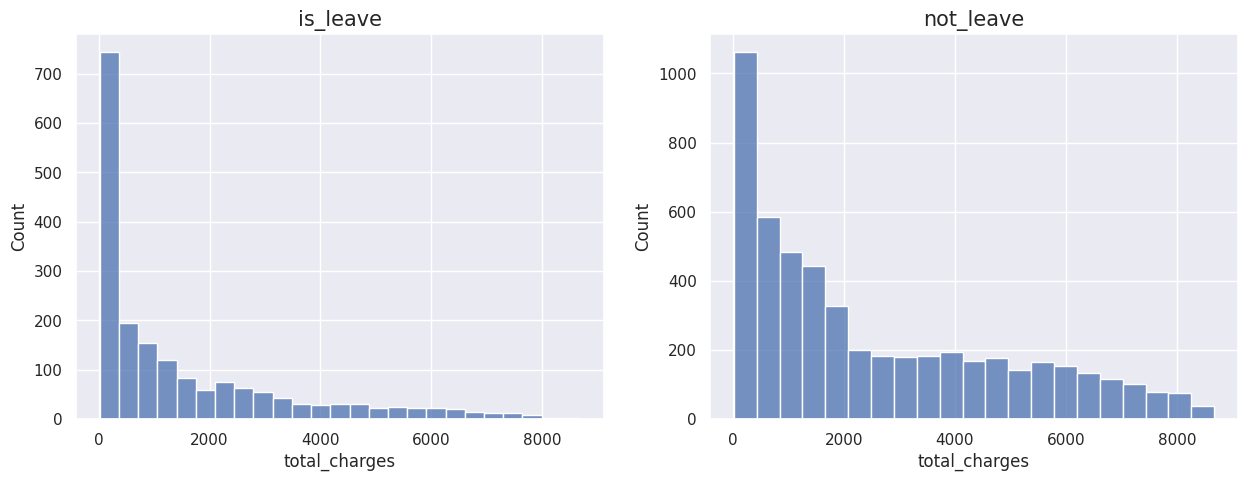

In [ ]:
ax1 = plt.subplot(1, 2, 1)
sns.set(rc={'figure.figsize':(15, 5)})
sns.histplot(leave_group['total_charges'])
plt.title('is_leave', fontsize=15);

ax2 = plt.subplot(1, 2, 2)
sns.set(rc={'figure.figsize':(15, 5)})
sns.histplot(not_leave_group['total_charges'])
plt.title('not_leave', fontsize=15);

leave_group

count    1869.000000
mean     1531.796094
std      1890.822994
min        18.850000
25%       134.500000
50%       703.550000
75%      2331.300000
max      8684.800000
Name: total_charges, dtype: float64

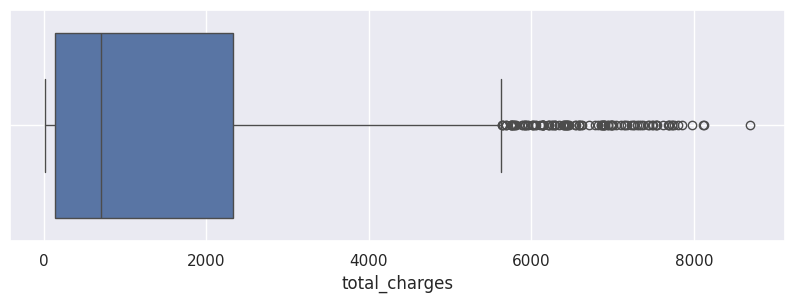

In [ ]:
plt.figure(figsize=(10,3))
sns.boxplot(leave_group['total_charges'], orient='h');
plt.grid(True)
leave_group['total_charges'].describe()

not_leave_group

count    5174.000000
mean     2549.999497
std      2329.858843
min        18.800000
25%       572.900000
50%      1679.525000
75%      4262.850000
max      8672.450000
Name: total_charges, dtype: float64

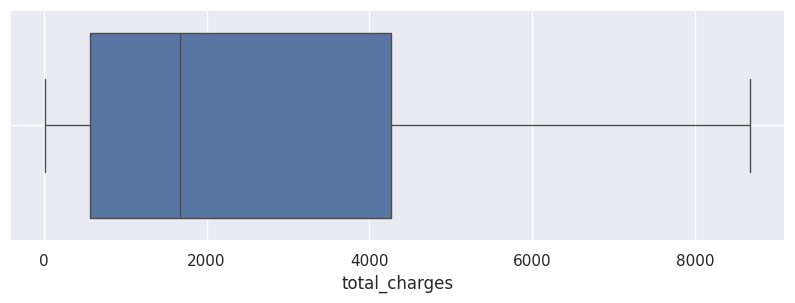

In [ ]:
plt.figure(figsize=(10,3))
sns.boxplot(not_leave_group['total_charges'], orient='h');
plt.grid(True)
not_leave_group['total_charges'].describe()

In [ ]:
print('median total charges of leave_group = ', leave_group['total_charges'].median())
print('median total charges of not_leave_group = ', not_leave_group['total_charges'].median())

median total charges of leave_group =  703.55
median total charges of not_leave_group =  1679.525


медианное значение общих трат в двух группах различаются, что бы проверить статистическую значимость этого отклонения, проведу тест  Краскела-Уоллиса на уровне значимости 0.05, так как размер выборок не одинаковые и данные не имеют нормальное распределение <br>
H0 -  Медиана одинакова для всех групп<br>
H1 - Медиана не одинакова для всех групп<br>

In [ ]:
p_value = kruskal(leave_group['total_charges'], not_leave_group['total_charges'])[1]
if p_value < 0.05:
    print('p_value = ', p_value, 'НЕ доастаточно основания для принятия Н0')
else:
    print('p_value = ', p_value, 'доастаточно основания для принятия Н0')

p_value =  3.937505733282122e-83 НЕ доастаточно основания для принятия Н0


так как p value < 0.05, то не имеется достаточно оснований принять гипотезу H0 о равенстве медианных значений в двух группах.

## Вывод

Более детальный анализ зависимости признака total_charges и leave показал, что признак имеет разные медианные значения у ушедших клиентов и не ушедших клментов. Это показал тест Краскела-Уоллиса на уровне значимости 0.05, где p_value < 0.05, а это значит, что разницы имеет статистическую значимость. Ушедшие клиенты тратили меньше.Это можно объяснить тем, клиенты были меньше заинтересованы в услугах.

# Общий вывод

В ходе исследователской работы была обучена модель машинного обучения - voting_classifier, в который входили модели случайного леса, решающего дерева и градиентного бустинга. Тестовое значение ROC_AUC получилось, как и минимальное ожидаемое значение - 0.85. Значения F1 на тесте равно 0.62, accuracy = 0.74, precision_score = 0.8, recall_score = 0.51. Модель с точностьб 80% опредлеяет ушедших клиентов, которые жддейстительно были ушедшими. Такой показатель хорош для бизнса, ведь лучше перестраховаться и считать, что клиент может потенциально уйти попытаться его удержать. Для улучшения модели следует иметь более полные данные, в которых будет меньше пропусков и меньший дисбаланс классов. Были выявлены 3 самых вляющих признака на на целевую переменную - уход клиента это оказались total_cahrges, montly_charges, duration, имеющие следующие коэфиценты 49, 30, 25 соответсвенно. О влиянии montly_charges было предположено еще по итогам исследователского анализа, так как этот признак имел разное распределения для ушедших и не ушедших клиентов. Проведенный детальный анализ зависимости total_cahrges и leave подтвердил наличие влияния данного признака,  так как медианные значения total_cahrges были разные для ушедших и не ушедших клиентов, что подтвердил тест тест Краскела-Уоллиса, медианное значение трат для ущедших клиентов = 703.55, для неушедших = 1679.525

## Бизнес рекомендации

Обращать внимание на общие и месячные траты клиента, а также на длительнойсть его контракт, так как это самые важные факторы, которые влияют на уход, а Если клиент тратит мало, то нужно предложить нужную ему услугу, что бы пвысить его интерес